# 2. Classification using Scikit-Learn
###### Ciaran Furey, 2021
This notebook will demonstrate how the datset was split into testing and training data, and how the classification of different supernovae (SNe) was carried out using different machine learning (ML) algorithms, provided by Scikit-Learn ([Pedregosa et al. 2011](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)). I will also explain th basic details I have learned about each algorithm as a result of this project.

Firstly, import the necessary modules.

In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize  # used to normalise colours
from matplotlib.gridspec import GridSpec # used for making axes of figures

import pandas as pd
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

from sklearn.metrics import plot_confusion_matrix # plots a confusion matrix
from sklearn.model_selection import GridSearchCV  # cross validation

Sklearn raises warnings, however, it does not affect the final code. In order to ignore these warnings, uncomment and run the following cell.

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

The `OpenSN` class.

In [2]:
class OpenSN:
    '''
    - Class that will open supernova photometry in a desired band from Open Astronomy Catalog API (OACAPI).
    - Provides a range of data, including redshift, claimed type and distance modulus.
    - Since this was created for the purpose of training and testing machine learning
      algorithms, light curves are interpolated using Gaussian Processes.
    - Provides option to plot the light curve in either MJD, or within a desired day
      range.
      
    ----------
    Inputs:
    name: string, name of SN
    band: string, the band to observe the light curve in
    t_min: int, lower bound of time interval (days since max), default = -10
    t_max: int, upper bound of time interval (days since max), default = 40 (t_max > t_min)
    num_steps: int, number of points to interpolate to, default = 200 (num_steps > 0)
    day_range: bool, option to view light curve within a range of days since max (True)
               or in MJD (False), default = True
    abs_mag: bool, option to view in terms of absolute mag, calculated from luminosity distance (True),
             or apparent magnitude (False), default = True 
    check_source: bool, option to return light curve from one source only, or to include photometry
                  from multiple sources. If there is more than one source, the source with the most
                  amount of data point is used. For example, SN2012fr. Default = True.
    exclude_no_errors: bool, option to exclude values with no uncertainty associated with them.
                       Default = True.
    verbose: bool, option to see what the class is doing upon instantiation. Default = False.
        
    ----------
    Outputs:
    raw_data: pandas dataframe containing all available photometry (time (MJD), 
              apparent magnitude, apparent magnitude error, band, source)
    redshift: redshift value, obtained from OACAPI.
    type: claimed type, obtained from OACAPI.
    dist_mod: distance modulus, calculated using the luminosity distance, obtained from OACAPI.
    meta: data returned from get_light_curve() function. This includes:
        - light_curve (meta[0])
          > photometry in desired band
        - interpolated_lc ([meta[1], meta[2]])
          > interpolated light curve (meta[1]), and the corresponding 1 sigma uncertainty (meta[2]),
            done using Gaussian Processes.
        - kernel (meta[3])
          > optimised kernel used for Gaussian Process interpolation.
       
    sources: the different sources of photometry in the desired band, and number of observations from each source.
    input: the interpolated light curve, used for machine learning input (meta[1])
    input_err: the interpolated light curve uncertainty, could be used for machine learning input (meta[2])
               
    ----------
    Oftentimes there may not be any photometry for a SN in desired band, or there may only be a few observations.
    To count for this, try and except blocks are used:
        - try load the data frame from the API,
        - except if it doesnt exist (ie: it raises error), return False.
    So when this is the case, False (bool) is returned. 
    
    In fact, if the data is not good enough (ie there are big gaps between points etc.), False is returned.This is
    useful when searching for data in the OACAPI.Suppose a list of type Ia SNe is loaded from the OACAPI. Then can
    use try and except blocks to check if a SN has a good light curve in the desired band or not. For example:
    
    for SN in list_of_Ias
        try:
            SN = OpenSN(SN, 'R')
            SN.input.any()
            ## save data to array
        except:
            pass
    
    Here, the SN is loaded, then ".any()" is called on the interpolated light curve. If there is data, this will simply
    return True, and the rest of the try statement will be carried out. However, if SN.input = False, this will raise
    an error and then except block will then be carried out.
    '''
    
    def __init__(self, name, band, t_min=-10, t_max=40, num_steps=200, day_range=True, abs_mag=True, check_source=True, 
                 exclude_no_errors=True, verbose=False):
        
        self.name = name                 # name of SN (string)
        self.band = band                 # band of desired light curve (string)
        self.t_min = t_min               # lower bound of day range (int)
        self.t_max = t_max               # upper bound of day range (int)
        self.day_range = day_range       # option to view in terms of day range, if desired (Bool)
        self.abs_mag = abs_mag           # option to veiw in terms of absolute magnitude, if desired (Bool)
        self.num_steps = num_steps       # number of datapoints to interpolate to (int)
        self.check_source = check_source # if want data points from only one source to be used (Bool)
        self.exclude_no_errors = exclude_no_errors # if want to exclude measurements with no error bars (Bool)
        self.verbose = verbose           # display what the class is doing (Bool)
                                         # useful for demonstration purposes and troubleshooting
        
        if self.verbose:
            t0=time.time()
        
        self.raw_data = self.load_data()    # initial pandas dataframe containing:
                                            # event, time (MJD), app_mag, e_mag, band
        
        self.redshift = self.get_redshift() # SN redshift
        
        self.type = self.get_type()         # SN type
            
        self.dist_mod = self.get_dist_mod() # distance modulus, obtained from luminosity distance
        
        try:
            self.meta = self.get_light_curve()
        except:
            if self.verbose:
                print('Light curve did not load, returning False.\n')
            self.meta = False
        try:
            self.meta[1].any()                    # if the light curve exists
            self.light_curve = self.meta[0]       # light curve in desired band
            self.interpolated_lc = np.array([self.meta[1], self.meta[2]]) # interpolated data and standard deviation
            self.kernel = self.meta[3]            # optimised kernel
            
        except:                                   # else, return False for everything
            self.light_curve = False
            self.interpolated_lc = False
            self.kernel = False
            
        self.sources = self.source_check()           # sources of data, and number of points of each source
        
        #ML DATA
        try:
            self.interpolated_lc.any()               # if the interpolated data exists
            self.input = self.interpolated_lc[0]     # return only the interpolated data
            self.input_err = self.interpolated_lc[1] # return standard deviation
        except:                                      # if it doesn't
            self.input = False                       # return False
            self.input_err = False
            
        if self.verbose:
            print('Finished in %.2f seconds.' % float(time.time()-t0))
        
        
        
    def load_data(self):
        '''Load data from API in .csv format'''
        
        if self.verbose:
            print(f'Loading data for {self.name} from API.\n')
        
        if ' ' in self.name: # if there is a space in the name, which cant be handled by API address,
            new_name = self.name.replace(' ', '%20') # replace with URL encoding.
            
            #eg for the type Ib 'MASTER OT J120451.50+265946.6' -> 'MASTER%20OT%20J120451.50+265946.6'
            
            try:             # then try open it on API.
                raw_data = pd.read_csv('https://api.astrocats.space/'+new_name+'/photometry/time+magnitude+e_magnitude+band+source?format=csv')
                if self.verbose: 
                    print('Data loaded.\n')
                return raw_data
            
            except:          # if it doesnt exist,
                if self.verbose:
                    print('Data not found, returning False.\n')
                return False # Return false.
            
        else: #if no space in the name, try open it.
            try: # load it from API
                raw_data = pd.read_csv('https://api.astrocats.space/'+self.name+'/photometry/time+magnitude+e_magnitude+band+source?format=csv')
                if self.verbose: 
                    print('Data loaded.\n')
                return raw_data
            
            except:
                if self.verbose:
                    print('Data not found, returning False.\n')
                return False # Return false if the directory doesnt exist.
            
        
    
    def get_light_curve(self):
        '''Obtain light curve of supernova in desired band'''
        
        if self.verbose:
            print('Cleaning data.\n')
        
        try:                            # if API directory exists
            out = self.raw_data.copy()  # make a copy of df from API, means dont have to load it each time
        except:
            return False                # Return false if the directory doesnt exist (SN2013dy)
        
        if self.verbose:
            print('Deleting nans.\n')
        
        if self.exclude_no_errors:     # if want to eclude datapoints with no error bars, 
            out = out.dropna(axis = 0) # delete NaNs across all columns 
        else:
            out = out.dropna(axis = 0, subset = ['event','time','magnitude','band','source'] )

        if self.verbose:
            print(f'Locating measurements in {self.band} band.\n')

        out = out.loc[out['band'] == self.band]  # locate band values
            
        try:
            if self.verbose:
                print('Converting time to float.\n')
            # time values are initially in string format, not sure why
            out.loc[:,'time'] = pd.to_numeric(out['time'])  # convert time to float 
        except:
            return False
        
        if self.day_range:
            out['time'] = out['time']/(1+self.redshift) # restframe time
        else:
            pass
                
        if self.check_source:                     # if want to use only one source
            mode = out['source'].mode().values[0] # find the source with the most data points (the mode)
            out = out.loc[out['source'] == mode]  # only use points from this source
        else:                                     # pass if not
            pass
            
        if len(out) < 10:  # if there are < 10 readings in desired band
            if self.verbose:
                print('There are not enough observations, returning False.')
            return False   # return False
        
        if self.day_range: # if want to observe in a range of days (relative to max brightness)
            if self.verbose:
                print(f'Converting from {self.t_min} to {self.t_max} days since {self.band} band max.\n')
            max_index = out.index[out['magnitude']==out['magnitude'].min()] # find brightest point
            max_time = out.loc[max_index]['time']                           # find index in the df at which this occurs
            t0 = max_time[max_index].values[0]                              # find MJD time of max brightness 
            
            out['time'] = out['time'] - t0  # convert time from MJD to time since max by subtracting this time
            
            # get values within desired day range
            # note that points outside range are being kept
            # this is because the LC will shift again such that the max of the interpolated curve is taken
            # as the max in the band
            out = out.loc[(out['time'] >= self.t_min-15) & (out['time'] <= self.t_max+20)] 
            

            # check if there is a datapoint close to boundaries
            # avoids poor interpolation (ie extrapolation, which is not desired)
            sn_tmin = out['time'].min() # earliest time observation was made 
            sn_tmax = out['time'].max() # latest time observation was made
            if (sn_tmin-self.t_min > 9 or self.t_max-sn_tmax > 10): #if min and max time close to bounds of time interval
                if self.verbose:
                    print('data points are too far away from bounds of time interval, returning False.\n')
                return False # as this is bad data
            else: 
                pass
        
        
        else:     # or else if want to observe in MJD
            pass  # do nothing
        
        if self.day_range:
            # check for large gaps between datapoints, which is not favoured by interpolation
            if self.verbose:
                print('checking for large gaps between observations.\n')
            times = out['time'].values # the times of each observation
            for i in range(1, len(times)): 
                if abs(times[i] - times[i-1]) < 30: # if the between a certain observation and the one before is < 30 days
                    pass                            # pass
                else:                               # if there is a gap > 30 days
                    if self.verbose:
                        print('found a gap greater than 30 days, returning False.\n')
                    return False                    # return False
        else:
            pass
        
        if self.abs_mag:                   # if want to observe in terms of absolute magnitude
            if self.verbose:
                print('Converting to absolute magnitude.\n')
            out['magnitude'] = out['magnitude'] - self.dist_mod # subtract dist mod from the apparent
                                                                # magnitudes to get absolute mags
        else:     # pass if not
            pass
        
        ### INTERPOLATION ###
            
        # for the kernel:
        #    - C = constant kernel, modifies covariance
        #    - RBF = Radial basis function. Squared exponential kernel, posterior of interpolation is Gaussian
        #    - WhiteKernel. Explains noise of data. The value of the diagonal entries of covariance matrix is
        #                   is equal to the value of the white kernel
        #
        # Each kernel has the same format:
        #    - KernelName(value, (lowerBound, upperBound))
        #
        # When optimising the parameters of the kernel, the eventual opitmal parameter is bound between the values
        # of upperBound and lowerBound. 
        kernel = C(1, (0.01, 50)) + RBF(1, (1, 15)) + WhiteKernel(1e-5, (1e-6,1e-1))

        
        if self.day_range:
            # regular grid of self.num_steps points between self.t_min-20 and self.t_max+15 to interpolate to.
            x = np.atleast_2d(np.linspace(self.t_min-15, self.t_max+15, self.num_steps)).T 
        else:
            min_t = out['time'].min() # mjd time of earliest observation
            max_t = out['time'].max() # mjd_time of latest observation
            x = np.atleast_2d(np.linspace(min_t, max_t, self.num_steps)).T

        X = np.atleast_2d(out['time'].values).T # the input data for the GP model (the times for each)
        y = out['magnitude'].values             # the output data for the GP model (magnitudes)
        yerr = out['e_magnitude'].values        # output uncertainty

        if self.verbose:
            print('Interpolating.\n')
            
        #instantiate a GP model, specifying kernel, alpha and the number of restarts until optimised
        if self.exclude_no_errors:
            gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr ** 2, n_restarts_optimizer=50)
        else:
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)
            
        gp.fit(X,y) #fit the model to the data
        y_pred, sigma = gp.predict(x, return_std=True)
        
        # now want to shift the interpolated LC such that time of max brightness is the time at which the
        # interpolated LC is brightest
        if self.day_range:
            if self.verbose:
                print('Now shifting time of max brightness to the time at which interpolation is brightest.\n')
            max_index_interp = np.where(y_pred == y_pred.min()) # find where INTERPOLATION is maximum
            tmax_interp = x[max_index_interp][0][0]             # find the time at which that occurred at
            new_x = x - tmax_interp                             # shift all times (for interpolation) by that time

            # now interpolate y_pred and sigma, which were originally over a range of
            # [t_min - 15, t_max + 20] (to account for this shift)
            # to the desired range of [t_min, t_max]
            new_y = np.interp(np.linspace(self.t_min, self.t_max, self.num_steps), new_x.flatten(), y_pred)  #interpolate
            new_sig = np.interp(np.linspace(self.t_min, self.t_max, self.num_steps), new_x.flatten(), sigma) #interpolate

            out['time'] = out['time'] - tmax_interp   #shift all times of measurement by time of max of interpolation
            # now need to get rid of points that may have fallen out of the desired range
            condition = (out['time']>self.t_min) & (out['time']<self.t_max) 
            
            out.loc[:,'time'] = out['time'][condition]
            out.loc[:,'magnitude'] = out['magnitude'][condition]
            out.loc[:,'e_magnitude'] = out['e_magnitude'][condition]
            if self.exclude_no_errors:
                out=out.dropna(axis = 0) # delete any NaNs that may have appeared
            else:
                out = out.dropna(axis = 0, subset = ['event','time','magnitude','band','source'] )
            
            return out, new_y, new_sig, gp.kernel_ 
        
        # or if in MJD, dont do day range
        else:
            return out, y_pred, sigma, gp.kernel_ 
                
        
        
        
    def source_check(self):
        '''sources of data in desired band'''
        if self.verbose:
            print('Loading Sources.\n')
        try:
            return self.light_curve['source'].value_counts()
        except:
            return False
    
    def get_redshift(self):
        '''redshift of supernova, taken as the value with the most sources'''
        if self.verbose:
            print('Loading redshift.')
        sn_zs = pd.read_json('https://api.astrocats.space/'+self.name+'/redshift+source')[self.name].loc['redshift']
        # sometimes there are different values given from redshift.
        # will take the one with the most sources attributed to it
        # eg SN1987A
        most_sources= np.argmax(np.array([len(sn_zs[i]['source']) for i in range(len(sn_zs))]))
        
        z=float(sn_zs[most_sources]['value'])
        
        if self.verbose:
            print(f'z = {z}\n')
        return z
        
    def get_type(self):
        '''return the type of supernova'''
        if self.verbose:
            print('Loading the claimed type.')
            
        if ' ' in self.name:
            new_name = self.name.replace(' ', '%20') # replace space with url encoding
            try:
                claimed_type = pd.read_csv('https://api.astrocats.space/'+new_name+'/claimedtype?format=csv')['claimedtype'].values[0]
                if self.verbose:
                    print(f'Claimed type: {claimed_type}\n')
                return claimed_type

            except:
                if self.verbose:
                    print('No type found, returning False.\n')
                return False # Return false if the directory doesnt exist
        else:
            try:
                claimed_type = pd.read_csv('https://api.astrocats.space/'+self.name+'/claimedtype?format=csv')['claimedtype'].values[0]
                if self.verbose:
                    print(f'Claimed type: {claimed_type}\n')
                return claimed_type
            except:
                if self.verbose:
                    print('No type found, returning False.\n')
                return False
                
    
    def get_dist_mod(self):
        '''
        returns distance moulus of a given supernova from luminosity distance, dL. This function returns:        
        distmod = 5log(dL/1Mpc) + 25,

        which in turn is used to calculate the absolute magnitude, M, using
           => M = m - distmod.
        '''
        if self.verbose:
            print('Calculating distance modulus from luminosity distance.')
            
            
        if ' ' in self.name: # if there is a space in the name, which cant be handled by API address,
            new_name = self.name.replace(' ', '%20') # replace with URL encoding.
            
            #eg for the type Ib 'MASTER OT J120451.50+265946.6' -> 'MASTER%20OT%20J120451.50+265946.6'
            
            try:             # then try open it on API.
                lumdist = pd.read_csv('https://api.astrocats.space/'+self.name+'/lumdist?format=csv')['lumdist'].values[0]
            except:          # if it doesnt exist,
                return False # Return false
            
        else: #if no space in the name, try open it.
            try: # load it from API
                lumdist = pd.read_csv('https://api.astrocats.space/'+self.name+'/lumdist?format=csv')['lumdist'].values[0]
            except:
                return False # Return false if the directory doesnt exist.
            
        dist_mod = 5*np.log10(lumdist) + 25
        
        if self.verbose:
            print(f'M-m = {dist_mod}\n')
        
        return dist_mod
        
    
    def plot_curve(self, interpolated = False, uncertainty=True, save=False):
        
        '''plot light curve of SN'''
        
        try:   
            self.light_curve.any() #will raise exception if false
            steps = int(np.round((self.t_max - self.t_min)/10 + 1)) #for xticks on eventual plot
            
            # define some colours to match the band
            colours={
                'V,v,v\'':['orangered','orange', 0.3],
                'G,g,g\'':['darkgreen','chartreuse', 0.3],
                'B,b':['blue','cornflowerblue',0.3],
                'U,u,u\'':['indigo', 'mediumpurple',0.3],
                'R':['darkred','r', 0.2]
            }
            
            for key in colours:
                if self.band in key:
                    sn_colours = colours[key]
                    break
                else: # since most other band are in the IR end of the spectrum
                    sn_colours = colours['R']
            
            fig = plt.figure() # make figure
            ax = fig.add_subplot(111)
            ax.errorbar(self.light_curve['time'], self.light_curve['magnitude'], yerr = self.light_curve['e_magnitude'],
                    fmt = '.', ms = '1', elinewidth = 0.5,
                    color = 'k', label='Data')

            if self.day_range:
                ax.set_xlabel(f'Phase (days since {self.band} band max)')
            else:
                ax.set_xlabel('Time (MJD)')

            if not self.abs_mag:
                ax.set_ylabel('Apparent Magnitude')
            else:
                ax.set_ylabel('Absolute Magnitude')

            if interpolated:
                if self.day_range:
                    t = np.linspace(self.t_min, self.t_max, self.num_steps)
                else:
                    min_t = self.light_curve['time'].min()
                    max_t = self.light_curve['time'].max()
                    t = np.linspace(min_t, max_t, self.num_steps)

                ax.plot(t, self.interpolated_lc[0], ls = '-', color = sn_colours[0], label='Interpolation', lw = 0.5) #plot the gp prediction
                if uncertainty:
                    ax.fill(np.concatenate([t, t[::-1]]),
                        np.concatenate([self.interpolated_lc[0] - 1.9600 * self.interpolated_lc[1], 
                                        (self.interpolated_lc[0] + 1.9600 * self.interpolated_lc[1])[::-1]]),
                        alpha=sn_colours[2], fc=sn_colours[1], ec='None', label='95% confidence interval') #plot the 95% confidence interval
                else:
                    pass
                
            if self.day_range:
                ax.set_xticks(np.linspace(self.t_min,self.t_max,steps))
                
            ax.invert_yaxis()
            plt.title(f'{self.band} band Light Curve {self.name}')
            plt.legend()
            if save:
                if interpolated:
                    is_interpolated=''
                else:
                    is_interpolated='not'
                    
                if uncertainty:
                    is_uncertainty=''
                else:
                    is_uncertainty='no'
                    
                if self.abs_mag:
                    mag = 'abs'
                else:
                    mag = 'app'
                    
                if self.day_range:
                    plt.savefig(f'{self.name}_{self.band}_{self.t_min}{self.t_max}{self.num_steps}_{mag}_{is_interpolated}interpolated_{is_uncertainty}confidence.jpg',
                               dpi=200)
                else:
                    plt.savefig(f'{self.name}_{self.band}_MJD_{mag}_{is_interpolated}interpolated_{is_uncertainty}confidence.jpg',
                               dpi=200)     
            plt.show()   
        except:
            return False

In [4]:
print(dir(OpenSN()))

TypeError: __init__() missing 2 required positional arguments: 'name' and 'band'

Next some parameters will be defined, such as the band, the time range, and the variable `norm`, which will decide whether the confusion matrices will be normalised or not.

In [4]:
band = 'R'      # desired band to use for classsification
t_min = -10     # lower bound for time interval
t_max = 40      # upper bound for time interval
num_steps = 200 # number of points in interval

x=np.linspace(t_min, t_max, num_steps) # will be used when visualising curves

## Loading Data
Next, load some data that has already been acquired, whose variable names use the following convention:

- The type of supernova, either `Ia`, `II`, or `Ibc`, followed by:
    - `X`: the non-normalised LC, in absolute magnitude.
    - `X_err`: the 1$\sigma$ uncertainty non-normalised LC, obtained from gaussian process fit.
    - `X_norm`: the normalised LC.
    - `X_err_norm`: the normalised LC uncertainty.
    - `y`: the SN type.
    - `names` are the names of each event, where the name corresponds to the value in each array at that index.
    
This `X` and `y` notation seems to be the standard notation used (in any coding examples on sklearn, anyway), where `X` is represents the input to a ML model, and `y` represents the output.

In [5]:
Ias_X = np.load('Ias_X_IaIIIbc.npy')
Ias_X_err = np.load('Ias_X_err_IaIIIbc.npy')
Ias_X_norm = np.load('Ias_X_norm_IaIIIbc.npy')
Ias_X_err_norm = np.load('Ias_X_norm_err_IaIIIbc.npy')
Ias_y = np.load('Ias_y_IaIIIbc.npy')
Ias_names = np.load('Ias_names_IaIIIbc.npy')

IIs_X = np.load('IIs_X_IaIIIbc.npy')
IIs_X_err = np.load('IIs_X_err_IaIIIbc.npy')
IIs_X_norm = np.load('IIs_X_norm_IaIIIbc.npy')
IIs_X_err_norm = np.load('IIs_X_norm_err_IaIIIbc.npy')
IIs_y = np.load('IIs_y_IaIIIbc.npy')
IIs_names = np.load('IIs_names_IaIIIbc.npy')

Ibcs_X = np.load('Ibcs_X_IaIIIbc.npy')
Ibcs_X_err = np.load('Ibcs_X_err_IaIIIbc.npy')
Ibcs_X_norm = np.load('Ibcs_X_norm_IaIIIbc.npy')
Ibcs_X_err_norm = np.load('Ibcs_X_norm_err_IaIIIbc.npy')
Ibcs_y = np.load('Ibcs_y_IaIIIbc.npy')
Ibcs_names = np.load('Ibcs_names_IaIIIbc.npy')

Some points to note:

- The `X` and `X_err` arrays were not used in this project, however, it could be interesting to see how the algorithms perform when these non-normalised LCs are used.
- The `err` arrays were not used, but they could be used in other applications. For example, [this work](https://arxiv.org/abs/2008.04921) (p7) discusses the use of gaussian process errors when training a recurrent neural network.

For this classification scheme, only Ias whose type is solely '`Ia`', according to the API, and likewise for type IIs, will be used, and, due to the lack of data, all Ibs and Ics will be considered as a single group: type Ib/c.

## Visualising Data

It is useful to visualise the data we are working with.
### Each curve separately

-#-#-#- TYPE IAS -#-#-#-


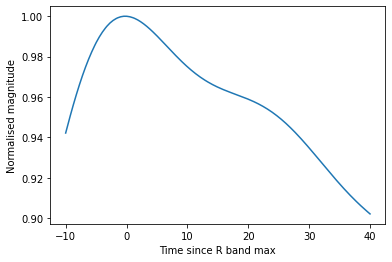

SN2002cr 



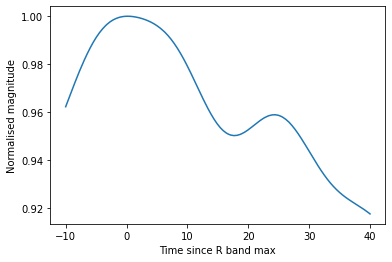

SN2002de 



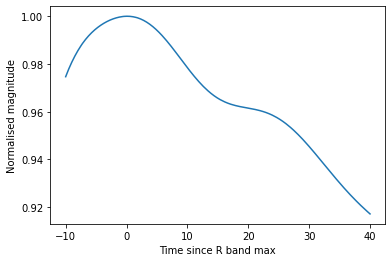

SN2002eb 



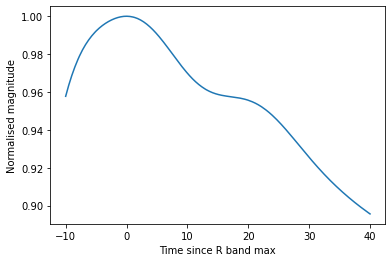

SN2002er 



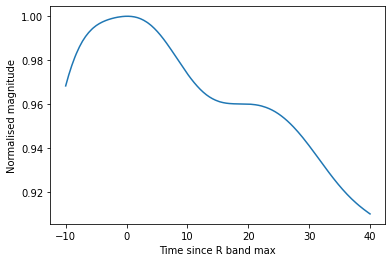

SN2002fk 



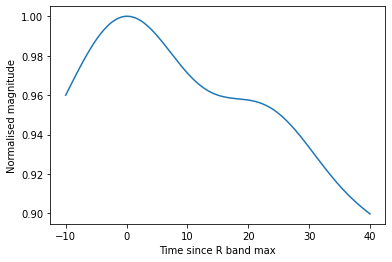

SN2003cg 



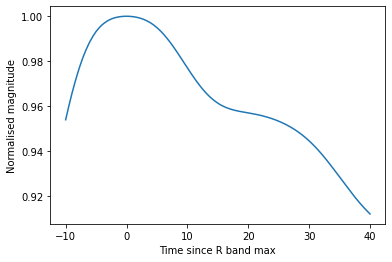

SN2003du 



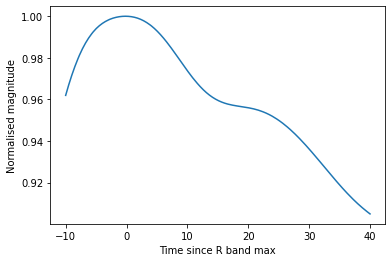

SN2003gt 



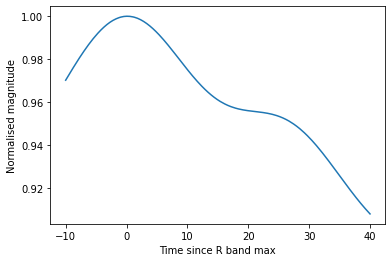

SN2003he 



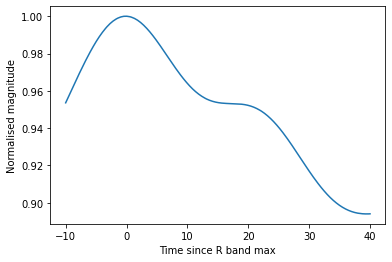

SN2004bw 



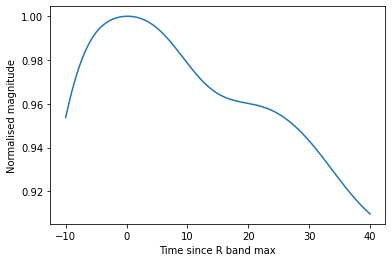

SN2005cf 



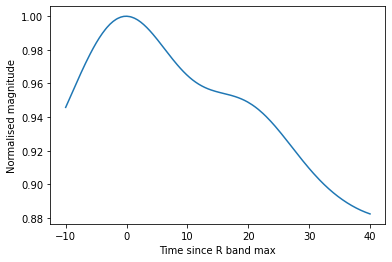

SN2006dm 



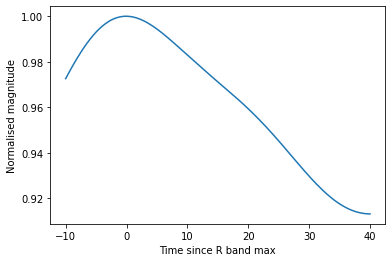

SN2006eu 



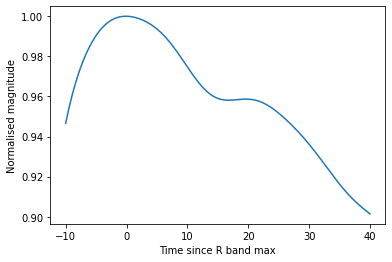

SN2011fe 



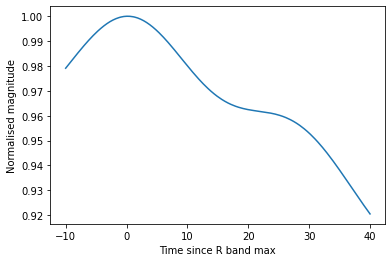

SN2011fs 



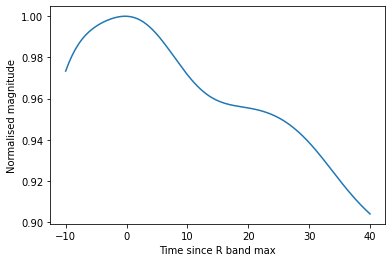

SN2012cg 



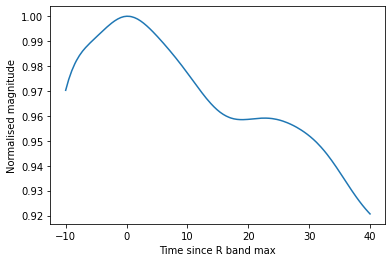

SN2012fr 



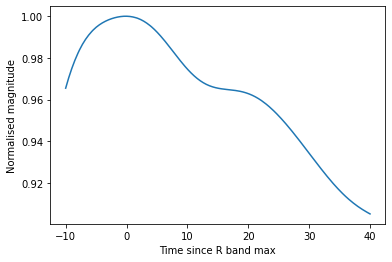

SN2013gy 



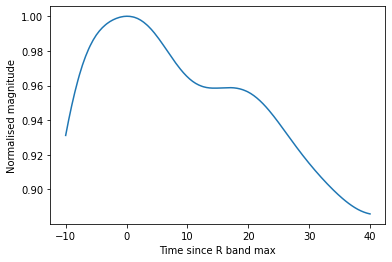

SN2016coj 



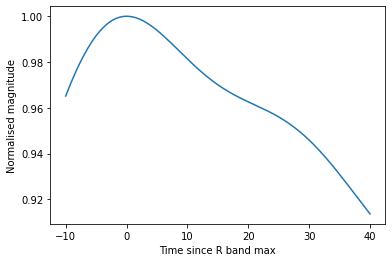

SN2016hvl 



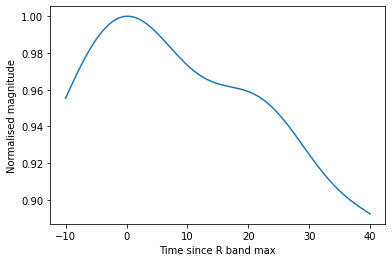

SN2017drh 



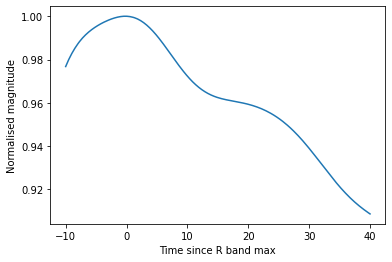

SN2017erp 



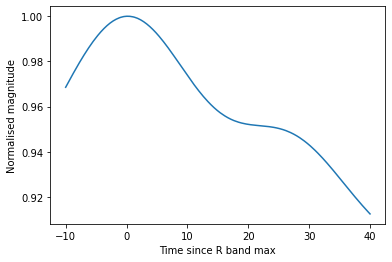

SN2018gv 



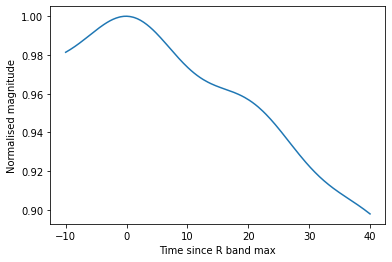

SN2007bc 


-#-#-#- TYPE IIS -#-#-#-


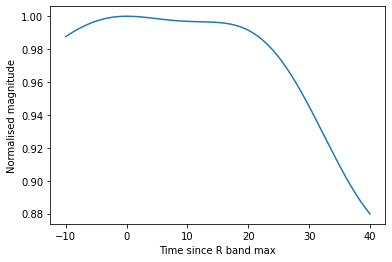

PTF11izt 



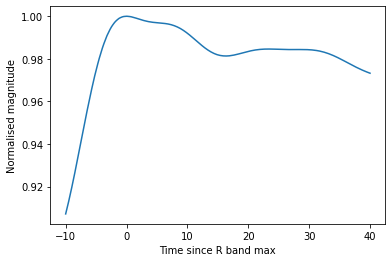

PTF11go 



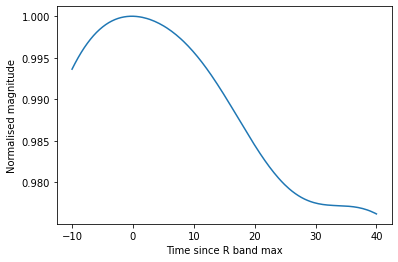

PTF11cwi 



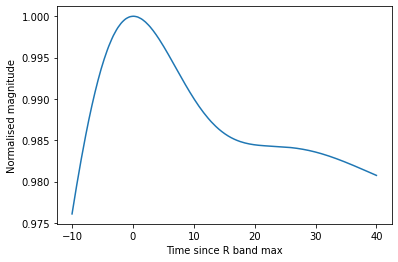

PTF10xtq 



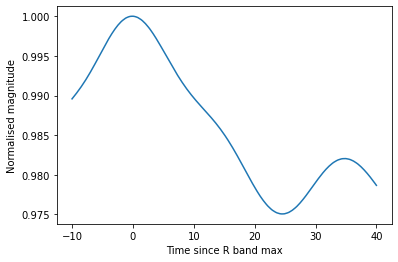

PTF10umz 



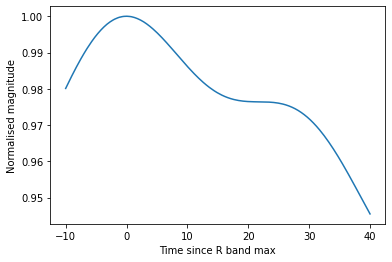

PTF10jwr 



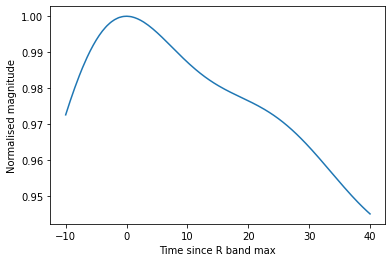

PTF10iam 



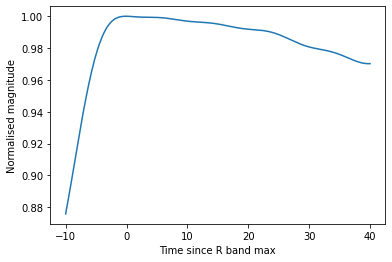

PTF10gva 



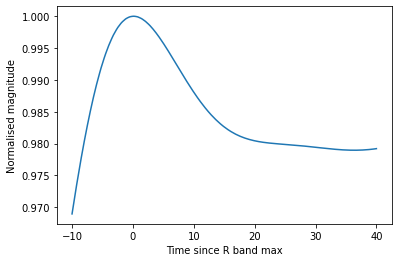

PTF10bgl 



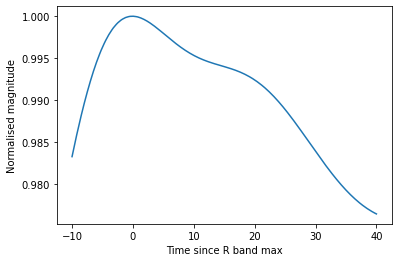

PTF09fma 



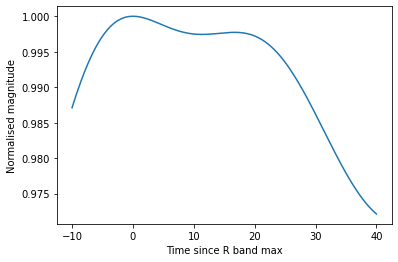

PTF09cjq 



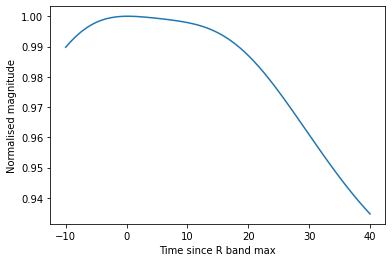

SN2005ci 



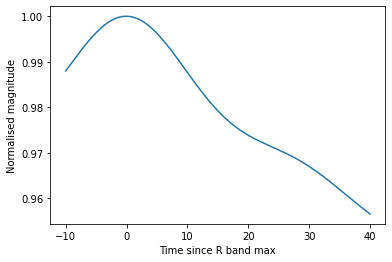

SN2008aw 



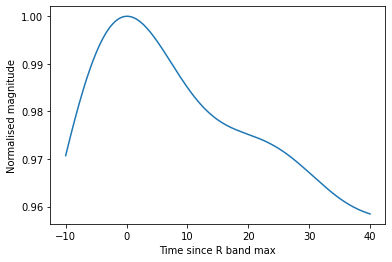

SN2008bx 



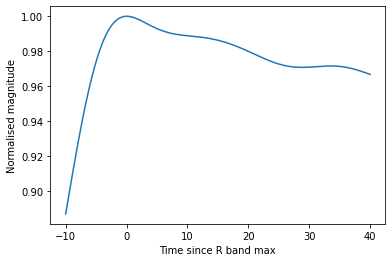

SN2009bw 



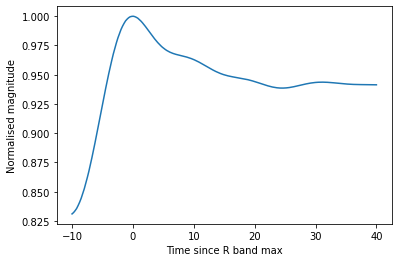

SN2016bkv 



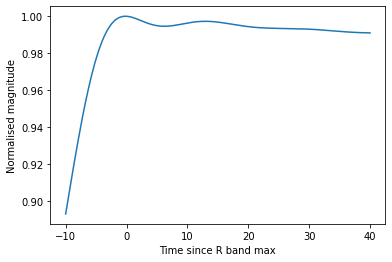

iPTF13dkz 



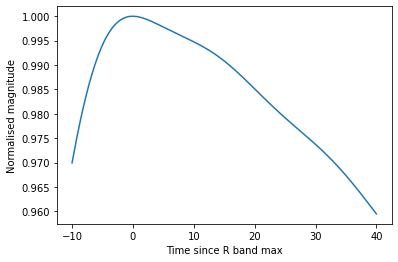

iPTF14adz 



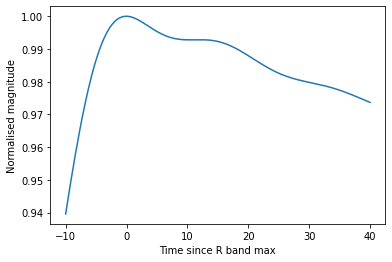

SN2016esw 



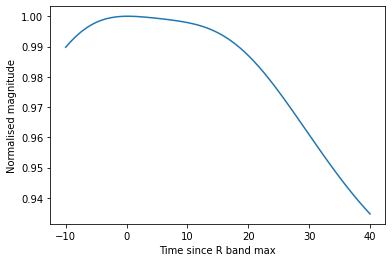

SN2005ci 



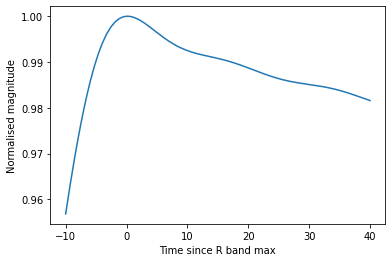

SN2004du 



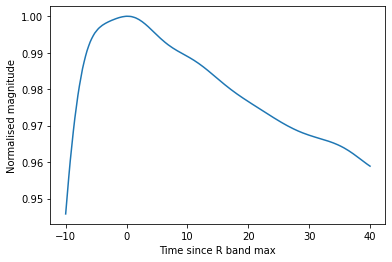

PTF10uls 



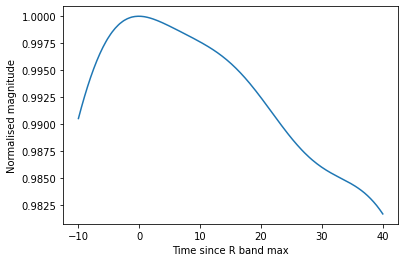

SN2005cl 



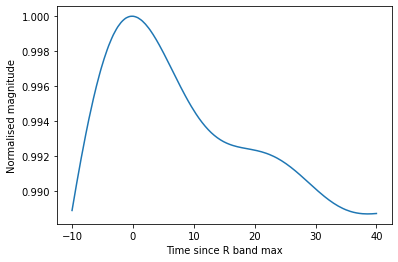

SN2009ib 


-#-#-#- TYPE IBCS -#-#-#-


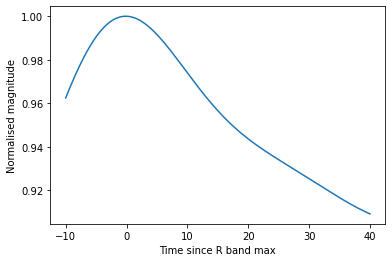

SN2004gq 



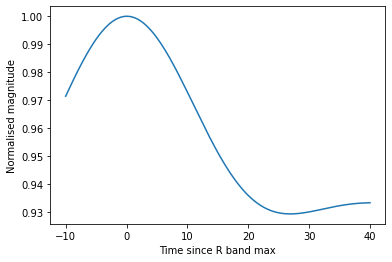

SN2006F 



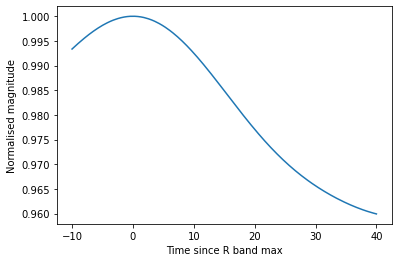

SN2006dn 



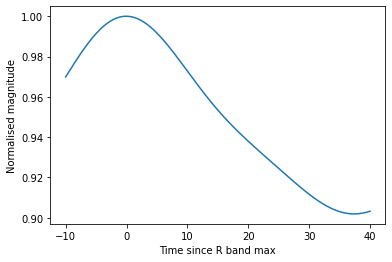

SN2007C 



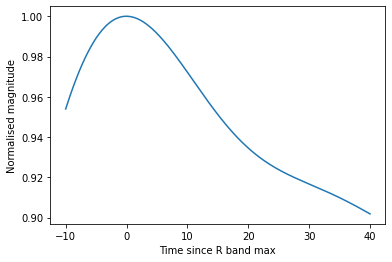

SN2008ax 



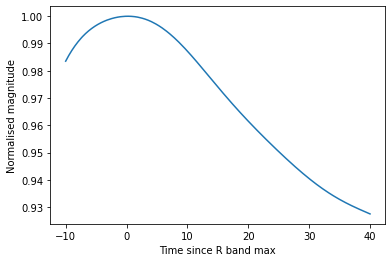

SN2009jf 



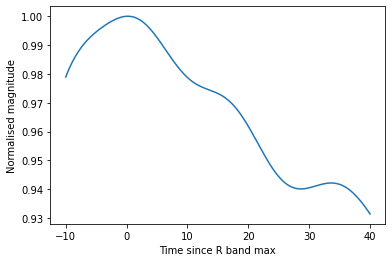

SN2016coi 



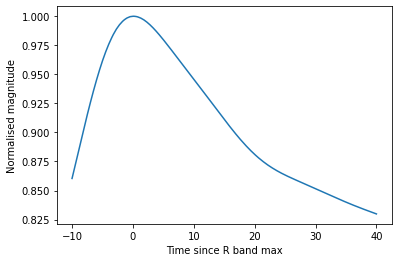

SN1994I 



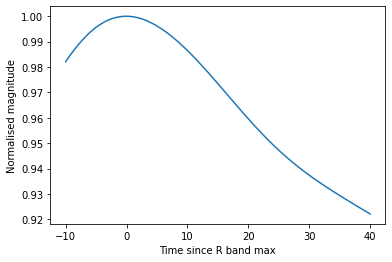

SN2004aw 



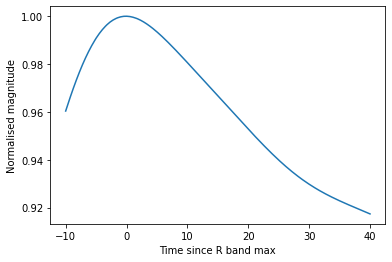

SN2004dn 



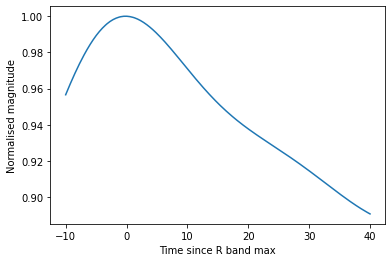

SN2004fe 



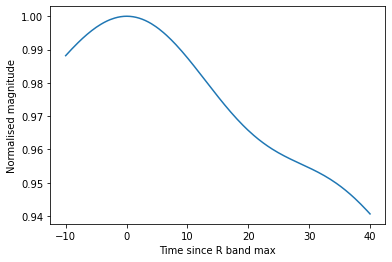

SN2004gt 



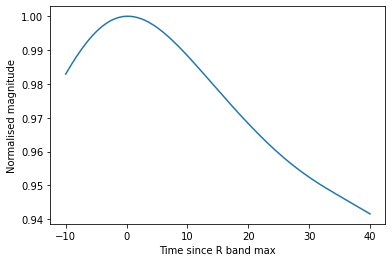

SN2005az 



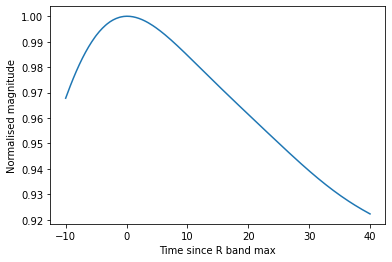

SN2005hg 



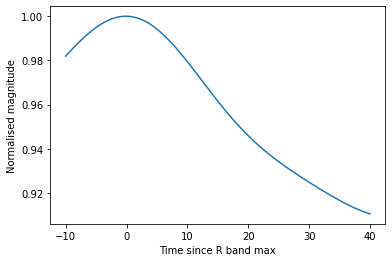

SN2005mf 



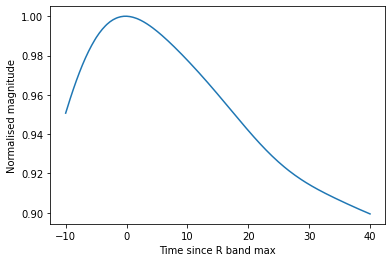

SN2007gr 



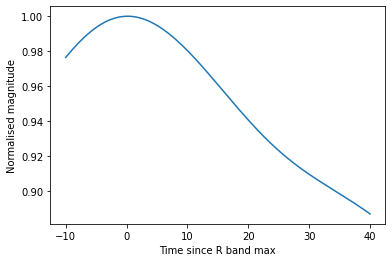

SN2007ru 



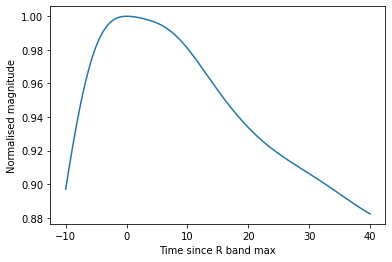

SN2009bb 



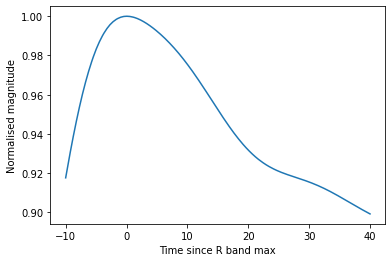

SN2014L 



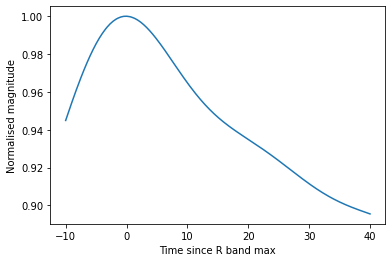

SN2014ad 



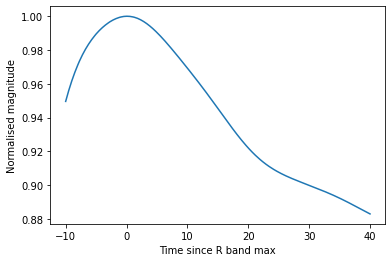

SN2017ein 



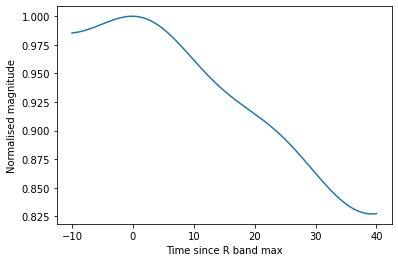

SN2003id 



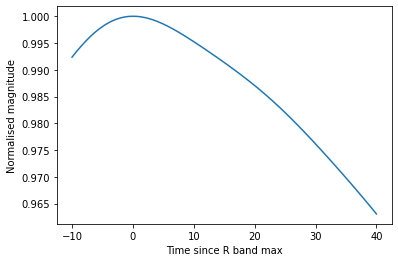

SN2011bm 



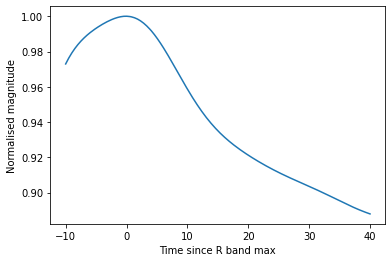

iPTF13bvn 



In [6]:
print('-#-#-#- TYPE IAS -#-#-#-')
for i,curve in enumerate(Ias_X_norm):
    plt.plot(x,curve)
    plt.xlabel(f'Time since {band} band max')
    plt.ylabel('Normalised magnitude')
    plt.show()
    print(Ias_names[i],'\n')
    
print('\n-#-#-#- TYPE IIS -#-#-#-')
for i,curve in enumerate(IIs_X_norm):
    plt.plot(x,curve)
    plt.xlabel(f'Time since {band} band max')
    plt.ylabel('Normalised magnitude')
    plt.show()
    print(IIs_names[i],'\n')

print('\n-#-#-#- TYPE IBCS -#-#-#-')
for i,curve in enumerate(Ibcs_X_norm):
    plt.plot(x,curve)
    plt.xlabel(f'Time since {band} band max')
    plt.ylabel('Normalised magnitude')
    plt.show()
    print(Ibcs_names[i],'\n')

### Figure of Curves

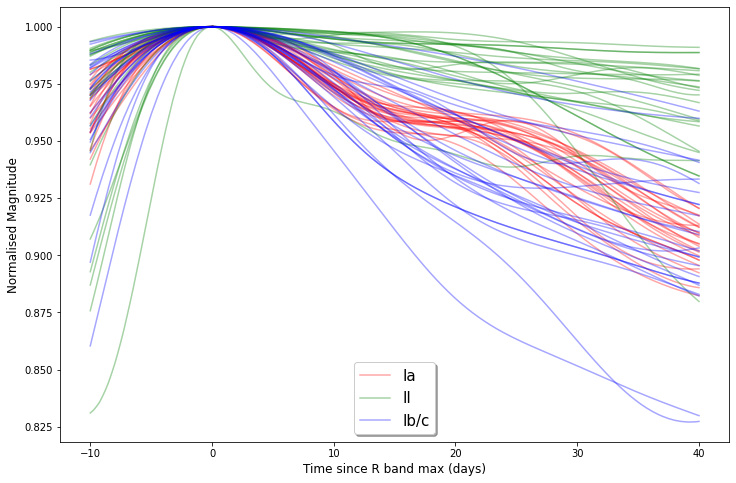

In [7]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for i in range(len(Ias_X_norm)):
    ax.plot(x,Ias_X_norm[i],'r',alpha=0.35)
    if i == len(Ias_X_norm)-1:
        ax.plot(x,Ias_X_norm[i],'r',alpha=0.35, label = 'Ia')
        
for i in range(len(IIs_X_norm)):
    if IIs_X_norm[i].min() < 0.8:
        pass
    else:
        ax.plot(x,IIs_X_norm[i],'g',alpha=0.35)
        if i == len(IIs_X_norm)-1:
            ax.plot(x,IIs_X_norm[i],'g',alpha=0.35, label = 'II')
        
for i in range(len(Ibcs_X_norm)):
    ax.plot(x,Ibcs_X_norm[i],'b',alpha=0.35)
    if i == len(Ibcs_X_norm)-1:
        ax.plot(x,Ibcs_X_norm[i],'b',alpha=0.35, label = 'Ib/c')
        
ax.set_xlabel(f'Time since {band} band max (days)', size='large')
ax.set_ylabel('Normalised Magnitude', size='large')
plt.legend(prop={'size': 15}, shadow=True)
# plt.savefig('data1.jpg', dpi = 230) 
plt.show()

# Splitting Data
In order to assess any ML model, it is important to split the main data set into two groups: one for training the model, called the **training set**, and one for testing the model, called the **testing set**. It is important that the testing set is not too big, or else the model will not be sufficiently trained, and not too small, or else the model will "over fit" the training set, that is; memorise the training set and not be able to confidently predict any testing examples. The built in sklearn function to perform this task, `sklearn.model_selection.train_test_split`, has a parameter `test_size` which is set to `0.25` by default, and "*represents the proportion of the dataset to include in the test split* ". 

Although there is a function provided to perform this very task, as mentioned above, a new method has been developed. This is because of the initial nature of the data: the data is already split into the 3 types. Also, an equal amount of each type is desired to minimise any bias. For eaxmple, if there were more type Ias in the training set, and Ib/c will likely be classified as a Ia etc. This process will take $n$ random curves from each type, so there will be $3n$ samples for testing the ML algorithms, with the rest used for training.    

In [8]:
import random

In [9]:
n=6
ints = list(range(len(Ias_X))) # list of numbers 0 - len(Ias_X) (= 24)
random.shuffle(ints)           # shuffle these numbers
for_testing = ints[:n]         # take first n from random sample

In [10]:
# DELTE the elements corresponding to these indices from main arrays for the TRAINING data
Ias_X_train = np.delete(Ias_X_norm, for_testing, axis=0)
IIs_X_train = np.delete(IIs_X_norm, for_testing, axis=0)
Ibcs_X_train = np.delete(Ibcs_X_norm, for_testing, axis=0)

Ias_y_train = np.delete(Ias_y, for_testing, axis=0)
IIs_y_train = np.delete(IIs_y, for_testing, axis=0)
Ibcs_y_train = np.delete(Ibcs_y, for_testing, axis=0)

In [11]:
# TAKE the elements corresponding to these indices from main arrays for the TESTING data
Ias_X_test = Ias_X_norm[for_testing]
IIs_X_test = IIs_X_norm[for_testing]
Ibcs_X_test = Ibcs_X_norm[for_testing]

Ias_y_test = Ias_y[for_testing]
IIs_y_test = IIs_y[for_testing]
Ibcs_y_test = Ibcs_y[for_testing]

Ias_name_test = Ias_names[for_testing]
IIs_name_test = IIs_names[for_testing]
Ibcs_name_test = Ibcs_names[for_testing]

In [12]:
# concatenate Ias, IIs, and Ib/cs to make full training and testing sets
X_train = np.concatenate((Ias_X_train, IIs_X_train, Ibcs_X_train))
X_test = np.concatenate((Ias_X_test, IIs_X_test, Ibcs_X_test))

y_train = np.concatenate((Ias_y_train, IIs_y_train, Ibcs_y_train))
y_test = np.concatenate((Ias_y_test, IIs_y_test, Ibcs_y_test))

In [13]:
print(f'There are {len(X_train)} training samples, and {len(X_test)} testing samples.')

There are 54 training samples, and 18 testing samples.


The following two functions have been developed in order to visualise the performance of the different sklearn algorithms.

The first function, `visualise_clf()`, provides a tile plot, confusion matrix, and a bar chart visualising the confidence of classification of the algorithm. The tile plot is like a confusion matrix, in that it compares the true label and the predicted label, however, instead it displays the event and its true label, and the probabilities of the type of event it is, according to the algorithm, thus giving a more complete insight into what the algorithm was thinking.

The second function, `compare_cv()`, is designed to directly compare the same algorithm before and after cross validation has been performed on it. 

Cross validation (CV) is a form of hyperparameter optimisation. In order to perform CV, the sklearn class `sklearn.model_selection.GridSearchCV()` is used, which takes, as an input, a 'grid' of different values for hyperparameters of a certain ML model and evaluates the performance of the model for each possible permutation of these parameters. See the [sklearn user guide](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) for more information. 

Te function `visualise_clf()` has an input `CV` which is either `True` or `False`, depending on whether CV has been performed on the model.


In [14]:
def visualise_clf(clf, CV, save=False):
    '''Visualise performance of different sklearn ML algorithms '''
    
    
    # Some parameters for different types of classifiers
    #
    # uses the format: 
    #'(first 3 letters of classifier)' : [(actual name of classifier, for title of plots), 
    #                                    (colourmap, to make visualisation unique),
    #                                    (abbreviation of name),
    #                                    (probabilty at which the text color changes, for clarity)
    #                                    (letter to be used in saving figures, so all figures are next to each other
    #                                     in the directory where they are saved)
    #                                     ]
    
    
    # Works by classifying the algorithm based on the first 3 letters of its name
    ## for example, suppose a random forest is instantiated using:
    ## rfc_clf = RandomForestClassifier()
    ## then the following command gives:
    ## print(str(rfc_clf)[:3])
    ## >>> Ran
    
    params = {'SVC' : ['Support Vector Classifier', plt.cm.viridis, 'SVC', 0.6, 'a'],
              'MLP' : ['Multi-Layered Perceptron NN', plt.cm.cividis, 'MLP NN', 0.6, 'b'],
              'Ran' : ['Random Forest Classifier', plt.cm.inferno, 'RFC', 0.6, 'c'],
              'KNe' : ['K-Nearest Neighbours Classifier', plt.cm.plasma, 'KNN', 0.6, 'd'],
              'Ada' : ['Adaboost Classifier', plt.cm.coolwarm, 'ABC', 0.4, 'f'],
              'Dec' : ['Decision Tree Classifier', plt.cm.YlGn, 'DTC', 0.0, 'g'],
              'Lin' : ['Linear Discriminant Analysis', plt.cm.magma, 'LDA', 0.3, 'h']
              }
    
    
    clf_name = str(clf)[:3] # first 3 letters of classifier
    
    if clf_name == 'Gau': # since it is the same for Gaussian Naive Bayes and Gaussian Process Classifier...
        clf_name_gau = str(clf)[:9] # take the first nine letters of the name
        gaussian_params = {
                  'GaussianP' : ['Gaussian Process Classifier', plt.cm.afmhot, 'GPC', 0.4, 'e'],
                  'GaussianN' : ['Gaussian Naive Bayes', plt.cm.gray, 'GNB', 0.3, 'h']
        }
        clf_params = gaussian_params[clf_name_gau] # set the parameters of the algorithm
    else:
        clf_params = params[clf_name] # the parameters of the algorithm
        

    clf_score = clf.score(X_test, y_test) # the mean accuracy of the classifier
    clf_probs = clf.predict_proba(X_test) # the predictions for each sample of test set, and their probabilities
    
    # also for titles of plots, need to state whether grid search cross validation (CV) has been performed
    # 'with_' is a varaible of type string that will say if CV has been done or not
    if CV: # if CV has been performed on input model
        with_ = 'with CV' 
    else:  # if it hasnt
        with_ = 'no CV'
        
        
    # if the plots are to be saved
    # will define a variable, 'has_CV', that will be used in the name of path where image will be saved
    # this will state whether CV has been performed on the algorithm
    if save:
        if CV:
            has_CV = ''
        else:
            has_CV = 'ano'
    else:
        pass
        
    Ia_probs = clf_probs[:n]    # probabilities for Ias
    II_probs = clf_probs[n:2*n] # probabilities for IIs
    Ibc_probs = clf_probs[2*n:] # probabilities for Ibcs
    
    
    # -------------------------------------------------- #    

    
    ### TILE PLOT OF PROBABILITIES ###
    

    fig = plt.figure(figsize=(13,7)) # instatiate figure object
    
    if n < 7: # to account for change in size of plot when number of samples changes
        gs_tile = GridSpec(1,3,fig,wspace=0.5)
    else:
        gs_tile = GridSpec(1,3,fig)

    #IA PLOT#
    Ia_ax = fig.add_subplot(gs_tile[0]) # Create axis
    
    # plot the probabilites of the Ias from the test set, using colourmap from params 
    Ia_plot = Ia_ax.imshow(Ia_probs, cmap = clf_params[1], vmin=0.0, vmax=1.0)
    
    #adjust and set x-ticks
    Ia_ax.set_xticks([0,1,2])
    Ia_ax.set_xticklabels(['II', 'Ia', 'Ib/c'])
    
    # print type of SN on vertical axis (ie the True Label)
    Ia_ax.set_yticks(range(len(y_test[:n])))
    Ia_ax.set_yticklabels(y_test[:n])

    Ia_ax.yaxis.set_ticks_position('both')
    
    # display probabilities on the tiles
    for i in range(len(Ia_probs)):
        for j in range(len(Ia_probs[i])):
            prob = Ia_probs[i][j]
            if prob >= clf_params[3]:
                c = 'k'
            else:
                c = 'w'
            Ia_ax.text(j,i,"{:.2f}".format(prob), va = 'center', ha = 'center', color = c)
    
    # display the SN names
    for i in range(len(clf_probs[:n])):
        Ia_ax.text(2.65,i,f'{Ias_name_test[i]}', va = 'center', ha = 'left', color = 'k')


    ### II PLOT ###
    II_ax = fig.add_subplot(gs_tile[1]) # Create axis

    # plot the probabilites of the IIs from the test set, using colourmap from params
    II_plot = II_ax.imshow(II_probs, cmap = clf_params[1], vmin=0.0, vmax=1.0) # create axis

    # adjust and set x-ticks
    II_ax.set_xticks([0,1,2])
    II_ax.set_xticklabels(['II', 'Ia', 'Ib/c'])

    # print type of SN on vertical axis (ie the True Label)
    II_ax.set_yticks(range(len(y_test[n:2*n])))
    II_ax.set_yticklabels(y_test[n:2*n])

    II_ax.yaxis.set_ticks_position('both')
    
    # display probabilities on the tiles
    for i in range(len(II_probs)):
        for j in range(len(II_probs[i])):
            prob = II_probs[i][j]
            if prob >= clf_params[3]:
                c = 'k'
            else:
                c = 'w'
            II_ax.text(j,i,"{:.2f}".format(prob), va = 'center', ha = 'center', color = c)

    # display the SN names
    for i in range(len(IIs_name_test)):
        II_ax.text(2.65,i,f'{IIs_name_test[i]}', va = 'center', ha = 'left', color = 'k')

    ### Ib/c PLOT ###
    Ibc_ax = fig.add_subplot(gs_tile[2]) # create axis

    # plot the probabilites of the Ibcs from the test set, using colourmap from params
    Ibc_plot = Ibc_ax.imshow(Ibc_probs, cmap = clf_params[1], vmin=0.0, vmax=1.0)

    # adjust and set x-ticks
    Ibc_ax.set_xticks([0,1,2])
    Ibc_ax.set_xticklabels(['II', 'Ia', 'Ib/c'])

    # print type of SN on vertical axis (ie the True Label)
    Ibc_ax.set_yticks(range(len(y_test[2*n:])))
    Ibc_ax.set_yticklabels(y_test[2*n:])

    Ibc_ax.yaxis.set_ticks_position('both')

    # display probabilities on the tiles
    for i in range(len(Ibc_probs)):
        for j in range(len(Ibc_probs[i])):
            prob = Ibc_probs[i][j]
            if prob >= clf_params[3]:
                c = 'k'
            else:
                c = 'w'
            Ibc_ax.text(j,i,"{:.2f}".format(prob), va = 'center', ha = 'center', color = c)

    # display the SN names
    for i in range(len(Ibcs_name_test)):
        Ibc_ax.text(2.65,i,f'{Ibcs_name_test[i]}', va = 'center', ha = 'left', color = 'k')
    
    if n < 7: # to account for change in size of plot when number of samples changes
        xlabel_x = 0.08
        ylabel_y = 0.05
    else:
        xlabel_x = 0.1
        ylabel_y = 0.03
        
    fig.text(0.5, ylabel_y, 'Predicted Label', ha='center', size = 'large')                  # y label
    fig.text(xlabel_x, 0.5, 'True Label', va='center', rotation='vertical', size = 'large')  # x label
     
    # sup-title
    plt.suptitle(f'{clf_params[0]} ({clf_params[2]}), {with_}, mean accuracy = %.2f' % clf_score, y = 0.95)
    
    if save:
        plt.savefig(f'ml_{clf_params[4]}_{clf_params[2]}_tileplot_{has_CV}CV.jpg',dpi=230)
    else:
        pass
    
    plt.show()
    
    # -------------------------------------------------- #    
    
    ### CONFUSION MATRIX ###
    
    plot_confusion_matrix(clf, 
                          X_test, 
                          y_test,
                          normalize=None,
                          colorbar=False, 
                          cmap = clf_params[1])
    plt.title(f'{clf_params[2]}, {with_}, mean accuracy = %.2f' % clf_score)
    
    if save:
        plt.savefig(f'ml_{clf_params[4]}_{clf_params[2]}_confusionmatrix_{has_CV}CV.jpg',dpi=230)
    else:
        pass
    
    plt.show()
    
    # -------------------------------------------------- #   
    
    ### CONFIDENCE BAR CHART ###
    #MAP CONFIDENCES TO COLOURS#
    
    Ia_conf = Ia_probs[:,1][np.argsort(Ia_probs[:,1])]    # sorted confidence of Ia predictions
    II_conf = II_probs[:,0][np.argsort(II_probs[:,0])]    # sorted confidence of II predictions
    Ibc_conf = Ibc_probs[:,2][np.argsort(Ibc_probs[:,2])] # sorted confidence of Ibc predictions
    
    Ia_mean_conf = np.mean(Ia_conf)   # mean confidence of Ia predictions
    II_mean_conf = np.mean(II_conf)   # mean confidence of II predictions
    Ibc_mean_conf = np.mean(Ibc_conf) # mean confidence of Ibc predictions
    
    Ia_conf_names = Ias_name_test[np.argsort(Ia_probs[:,1])]    # corresponding Ia names
    II_conf_names = IIs_name_test[np.argsort(II_probs[:,0])]    # corresponding II names
    Ibc_conf_names = Ibcs_name_test[np.argsort(Ibc_probs[:,2])] # corresponding Ibc names
    
    norm = Normalize(vmin=0.0, vmax=1.0)  # object that will map a Scalarmappable object to between 0 and 1
    
    # map Ia confidences to a color in colormap, and return rgba value
    Ia_mapper = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(Ia_conf)
    
    # map II confidences to a color in colormap, and return rgba value
    II_mapper = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(II_conf)
    
    # map Ibc confidences to a color in colormap, and return rgba value
    Ibc_mapper = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(Ibc_conf)
        
    #CREATE FIGURE#
    conf_fig = plt.figure(figsize=(6,10)) # instantiate figure object
    
    gs = GridSpec(3,1, conf_fig, hspace=0.25) # create axis grid using gridspec
    
    # Ia plot
    Ia_conf_ax = conf_fig.add_subplot(gs[0]) # create axis
    Ia_conf_ax.bar(Ia_conf_names, Ia_conf, color=Ia_mapper, edgecolor='black') # plot confidences
    Ia_conf_ax.text(1,1.01,'Ias',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = Ia_conf_ax.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    Ia_mean_conf_line = Ia_conf_ax.axhline(Ia_mean_conf, ls='--')
    Ia_conf_ax.text(1.02,Ia_mean_conf, '%.2f' % (Ia_mean_conf),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = Ia_conf_ax.transAxes,
                     c = Ia_mean_conf_line.get_color()) # label mean confidence
    # set xlabel to SNe names
    Ia_conf_ax.set_xticklabels(Ia_conf_names, rotation=20, ha='right') 
    Ia_conf_ax.set_ylim(0,1.05) # set y axis limit
    Ia_conf_ax.set_ylabel('Confidence (%)') # set y label
    
    # II plot
    II_conf_ax = conf_fig.add_subplot(gs[1]) # create axis
    II_conf_ax.bar(II_conf_names, II_conf, color=II_mapper, edgecolor='black') # plot confidences
    II_conf_ax.text(1,1.01,'IIs',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = II_conf_ax.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    II_mean_conf_line = II_conf_ax.axhline(II_mean_conf, ls='--')
    II_conf_ax.text(1.02,II_mean_conf, '%.2f' % (II_mean_conf),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = II_conf_ax.transAxes,
                     c = II_mean_conf_line.get_color()) # label mean confidence
    # set xlabe to SNe names
    II_conf_ax.set_xticklabels(II_conf_names, rotation=20, ha='right') 
    II_conf_ax.set_ylim(0,1.05) # set y axis limit
    II_conf_ax.set_ylabel('Confidence (%)') # set y label
    
    # Ibc plot
    Ibc_conf_ax = conf_fig.add_subplot(gs[2]) # create axis
    Ibc_conf_ax.bar(Ibc_conf_names, Ibc_conf, color=Ibc_mapper, edgecolor='black') # plot confidences
    Ibc_conf_ax.text(1,1.01,'Ibcs',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = Ibc_conf_ax.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    Ibc_mean_conf_line = Ibc_conf_ax.axhline(Ibc_mean_conf, ls='--')
    Ibc_conf_ax.text(1.02,Ibc_mean_conf, '%.2f' % (Ibc_mean_conf),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = Ibc_conf_ax.transAxes,
                     c = Ibc_mean_conf_line.get_color()) # label mean confidence
    # set xlabe to SNe names
    Ibc_conf_ax.set_xticklabels(Ibc_conf_names, rotation=20, ha='right') 
    Ibc_conf_ax.set_ylim(0,1.05) # set y axis limit
    Ibc_conf_ax.set_ylabel('Confidence (%)') # set y label
    
    conf_fig.suptitle(f'{clf_params[2]} classification confidence, {with_}',y=0.9) # suptitle
    if save:
        plt.savefig(f'ml_{clf_params[4]}_{clf_params[2]}_barchart_{has_CV}CV.jpg',dpi=230)
    else:
        pass
    
    plt.show()

In [15]:
def compare_cv(clf_nocv, clf_cv, save=False):
    '''Compare two of the same classifiers before and after cross validation'''
    
    #same parameters as visualise_clf() 
    params = {'SVC' : ['Support Vector Classifier', plt.cm.viridis, 'SVC', 0.6, 'a'],
              'MLP' : ['Multi-Layered Perceptron NN', plt.cm.cividis, 'MLP NN', 0.6, 'b'],
              'Ran' : ['Random Forest Classifier', plt.cm.inferno, 'RFC', 0.6, 'c'],
              'KNe' : ['K-Nearest Neighbours Classifier', plt.cm.plasma, 'KNN', 0.6, 'd'],
              'Ada' : ['Adaboost Classifier', plt.cm.coolwarm, 'ABC', 0.2, 'f'],
              'Dec' : ['Decision Tree Classifier', plt.cm.YlGn, 'DTC', 0.0, 'g'],
              'Lin' : ['Linear Discriminant Analysis', plt.cm.magma, 'LDA', 0.3, 'h']
              }
    
    clf_name = str(clf_nocv)[:3]       # first 3 letters of classifier
    
    if clf_name == 'Gau': # since it is the same for Gaussian Naive Bayes and Gaussia Process Classifier...
        clf_name_gau = str(clf_nocv)[:9] # take the first nine letters of the name
        gaussian_params = {
                  'GaussianP' : ['Gaussian Process Classifier', plt.cm.afmhot, 'GPC', 0.4, 'e'],
                  'GaussianN' : ['Gaussian Naive Bayes', plt.cm.gray, 'GNB', 0.3, 'h']
        }
        clf_params = gaussian_params[clf_name_gau] # set the parameters of the algorithm
    else:
        clf_params = params[clf_name] # the parameters of the algorithm
        
    score_nocv = clf_nocv.score(X_test, y_test) # the mean accuracy of the classifier
    probs_nocv = clf_nocv.predict_proba(X_test) # the predictions for each sample of test set, and their probabilities
    
    score_cv = clf_cv.score(X_test, y_test) # the mean accuracy of the classifier
    probs_cv = clf_cv.predict_proba(X_test) # the predictions for each sample of test set, and their probabilities
    
    Ia_probs_nocv = probs_nocv[:n]    # probabilities for Ias
    II_probs_nocv = probs_nocv[n:2*n] # probabilities for IIs
    Ibc_probs_nocv = probs_nocv[2*n:] # probabilities for Ibcs
    
    Ia_probs_cv = probs_cv[:n]    # probabilities for Ias
    II_probs_cv = probs_cv[n:2*n] # probabilities for IIs
    Ibc_probs_cv = probs_cv[2*n:] # probabilities for Ibcs
    
    Ia_conf_nocv = Ia_probs_nocv[:,1][np.argsort(Ia_probs_nocv[:,1])]    # sorted confidence of Ia predictions
    II_conf_nocv = II_probs_nocv[:,0][np.argsort(II_probs_nocv[:,0])]    # sorted confidence of II predictions
    Ibc_conf_nocv = Ibc_probs_nocv[:,2][np.argsort(Ibc_probs_nocv[:,2])] # sorted confidence of Ibc predictions
    
    Ia_mean_conf_nocv = np.mean(Ia_conf_nocv)   # mean confidence of Ia predictions
    II_mean_conf_nocv = np.mean(II_conf_nocv)   # mean confidence of II predictions
    Ibc_mean_conf_nocv = np.mean(Ibc_conf_nocv) # mean confidence of Ibc predictions
    
    Ia_conf_names_nocv = Ias_name_test[np.argsort(Ia_probs_nocv[:,1])]    # corresponding Ia names
    II_conf_names_nocv = IIs_name_test[np.argsort(II_probs_nocv[:,0])]    # corresponding II names
    Ibc_conf_names_nocv = Ibcs_name_test[np.argsort(Ibc_probs_nocv[:,2])] # corresponding Ibc names
    
    Ia_conf_cv = Ia_probs_cv[:,1][np.argsort(Ia_probs_cv[:,1])]    # sorted confidence of Ia predictions
    II_conf_cv = II_probs_cv[:,0][np.argsort(II_probs_cv[:,0])]    # sorted confidence of II predictions
    Ibc_conf_cv = Ibc_probs_cv[:,2][np.argsort(Ibc_probs_cv[:,2])] # sorted confidence of Ibc predictions
    
    Ia_mean_conf_cv = np.mean(Ia_conf_cv)   # mean confidence of Ia predictions
    II_mean_conf_cv = np.mean(II_conf_cv)   # mean confidence of II predictions
    Ibc_mean_conf_cv = np.mean(Ibc_conf_cv) # mean confidence of Ibc predictions
    
    Ia_conf_names_cv = Ias_name_test[np.argsort(Ia_probs_cv[:,1])]    # corresponding Ia names
    II_conf_names_cv = IIs_name_test[np.argsort(II_probs_cv[:,0])]    # corresponding II names
    Ibc_conf_names_cv = Ibcs_name_test[np.argsort(Ibc_probs_cv[:,2])] # corresponding Ibc names
    
    norm = Normalize(vmin=0.0, vmax=1.0)  # object that will map a Scalarmappable object to between 0 and 1
    
    # map Ia confidences to a color in colormap, and return rgba value
    Ia_mapper_nocv = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(Ia_conf_nocv)
    
    # map II confidences to a color in colormap, and return rgba value
    II_mapper_nocv = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(II_conf_nocv)
    
    # map Ibc confidences to a color in colormap, and return rgba value
    Ibc_mapper_nocv = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(Ibc_conf_nocv)
    
    # map Ia confidences to a color in colormap, and return rgba value
    Ia_mapper_cv = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(Ia_conf_cv)
    
    # map II confidences to a color in colormap, and return rgba value
    II_mapper_cv = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(II_conf_cv)
    
    # map Ibc confidences to a color in colormap, and return rgba value
    Ibc_mapper_cv = plt.cm.ScalarMappable(norm=norm, cmap=clf_params[1]).to_rgba(Ibc_conf_cv)
        
    #CREATE FIGURE#
    conf_fig = plt.figure(figsize=(15,10)) # instantiate figure object
    
    gs = GridSpec(3,2, conf_fig, hspace=0.25, wspace=0.25) # create axis grid using gridspec
    
    # Ia plot
    Ia_conf_ax_nocv = conf_fig.add_subplot(gs[0,0]) # create axis
    Ia_conf_ax_nocv.bar(Ia_conf_names_nocv, Ia_conf_nocv, color=Ia_mapper_nocv, edgecolor='black') # plot confidences
    Ia_conf_ax_nocv.text(1,1.01,'Ias',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = Ia_conf_ax_nocv.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    Ia_mean_conf_line_nocv = Ia_conf_ax_nocv.axhline(Ia_mean_conf_nocv, ls='--')
    Ia_conf_ax_nocv.text(1.02,Ia_mean_conf_nocv, '%.2f' % (Ia_mean_conf_nocv),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = Ia_conf_ax_nocv.transAxes,
                     c = Ia_mean_conf_line_nocv.get_color()) # label mean confidence
    # set xlabe to SNe names
    Ia_conf_ax_nocv.set_xticklabels(Ia_conf_names_nocv, rotation=20, ha='right') 
    Ia_conf_ax_nocv.set_ylim(0,1.05) # set y axis limit
    Ia_conf_ax_nocv.set_ylabel('Confidence (%)') # set y label
    Ia_conf_ax_nocv.set_title('No CV')
    
    # II plot
    II_conf_ax_nocv = conf_fig.add_subplot(gs[1,0]) # create axis
    II_conf_ax_nocv.bar(II_conf_names_nocv, II_conf_nocv, color=II_mapper_nocv, edgecolor='black') # plot confidences
    II_conf_ax_nocv.text(1,1.01,'IIs',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = II_conf_ax_nocv.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    II_mean_conf_line_nocv = II_conf_ax_nocv.axhline(II_mean_conf_nocv, ls='--')
    II_conf_ax_nocv.text(1.02,II_mean_conf_nocv, '%.2f' % (II_mean_conf_nocv),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = II_conf_ax_nocv.transAxes,
                     c = II_mean_conf_line_nocv.get_color()) # label mean confidence
    # set xlabe to SNe names
    II_conf_ax_nocv.set_xticklabels(II_conf_names_nocv, rotation=20, ha='right') 
    II_conf_ax_nocv.set_ylim(0,1.05) # set y axis limit
    II_conf_ax_nocv.set_ylabel('Confidence (%)') # set y label
    
    # Ibc plot
    Ibc_conf_ax_nocv = conf_fig.add_subplot(gs[2,0]) # create axis
    Ibc_conf_ax_nocv.bar(Ibc_conf_names_nocv, Ibc_conf_nocv, color=Ibc_mapper_nocv, edgecolor='black') # plot confidences
    Ibc_conf_ax_nocv.text(1,1.01,'Ibcs',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = Ibc_conf_ax_nocv.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    Ibc_mean_conf_line_nocv = Ibc_conf_ax_nocv.axhline(Ibc_mean_conf_nocv, ls='--')
    Ibc_conf_ax_nocv.text(1.02,Ibc_mean_conf_nocv, '%.2f' % (Ibc_mean_conf_nocv),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = Ibc_conf_ax_nocv.transAxes,
                     c = Ibc_mean_conf_line_nocv.get_color()) # label mean confidence
    # set xlabe to SNe names
    Ibc_conf_ax_nocv.set_xticklabels(Ibc_conf_names_nocv, rotation=20, ha='right') 
    Ibc_conf_ax_nocv.set_ylim(0,1.05) # set y axis limit
    Ibc_conf_ax_nocv.set_ylabel('Confidence (%)') # set y label
    
    
    # Ia plot
    Ia_conf_ax_cv = conf_fig.add_subplot(gs[0,1]) # create axis
    Ia_conf_ax_cv.bar(Ia_conf_names_cv, Ia_conf_cv, color=Ia_mapper_cv, edgecolor='black') # plot confidences
    Ia_conf_ax_cv.text(1,1.01,'Ias',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = Ia_conf_ax_cv.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    Ia_mean_conf_line_cv = Ia_conf_ax_cv.axhline(Ia_mean_conf_cv, ls='--')
    Ia_conf_ax_cv.text(1.02,Ia_mean_conf_cv, '%.2f' % (Ia_mean_conf_cv),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = Ia_conf_ax_cv.transAxes,
                     c = Ia_mean_conf_line_cv.get_color()) # label mean confidence
    # set xlabe to SNe names
    Ia_conf_ax_cv.set_xticklabels(Ia_conf_names_cv, rotation=20, ha='right') 
    Ia_conf_ax_cv.set_ylim(0,1.05) # set y axis limit
    Ia_conf_ax_cv.set_ylabel('Confidence (%)') # set y label
    Ia_conf_ax_cv.set_title('CV')
    
    # II plot
    II_conf_ax_cv = conf_fig.add_subplot(gs[1,1]) # create axis
    II_conf_ax_cv.bar(II_conf_names_cv, II_conf_cv, color=II_mapper_cv, edgecolor='black') # plot confidences
    II_conf_ax_cv.text(1,1.01,'IIs',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = II_conf_ax_cv.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    II_mean_conf_line_cv = II_conf_ax_cv.axhline(II_mean_conf_cv, ls='--')
    II_conf_ax_cv.text(1.02,II_mean_conf_cv, '%.2f' % (II_mean_conf_cv),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = II_conf_ax_cv.transAxes,
                     c = II_mean_conf_line_cv.get_color()) # label mean confidence
    # set xlabe to SNe names
    II_conf_ax_cv.set_xticklabels(II_conf_names_cv, rotation=20, ha='right') 
    II_conf_ax_cv.set_ylim(0,1.05) # set y axis limit
    II_conf_ax_cv.set_ylabel('Confidence (%)') # set y label
    
    # Ibc plot
    Ibc_conf_ax_cv = conf_fig.add_subplot(gs[2,1]) # create axis
    Ibc_conf_ax_cv.bar(Ibc_conf_names_cv, Ibc_conf_cv, color=Ibc_mapper_cv, edgecolor='black') # plot confidences
    Ibc_conf_ax_cv.text(1,1.01,'Ibcs',
                    ha='right', va='bottom',
                    size = 'large',
                    transform = Ibc_conf_ax_cv.transAxes) # label axis 
    # plot the mean confidence as a horizontal line
    Ibc_mean_conf_line_cv = Ibc_conf_ax_cv.axhline(Ibc_mean_conf_cv, ls='--')
    Ibc_conf_ax_cv.text(1.02,Ibc_mean_conf_cv, '%.2f' % (Ibc_mean_conf_cv),
                     ha = 'left', va='top',
                     size = 'medium',
                     transform = Ibc_conf_ax_cv.transAxes,
                     c = Ibc_mean_conf_line_cv.get_color()) # label mean confidence
    # set xlabe to SNe names
    Ibc_conf_ax_cv.set_xticklabels(Ibc_conf_names_cv, rotation=20, ha='right') 
    Ibc_conf_ax_cv.set_ylim(0,1.05) # set y axis limit
    Ibc_conf_ax_cv.set_ylabel('Confidence (%)') # set y label
    
    conf_fig.suptitle(f'{clf_params[2]} classification confidence',y=0.95)# {with_}',y=0.9) # suptitle
    if save:
        plt.savefig(f'ml_{clf_params[4]}_{clf_params[2]}_abarchart_CVcomparison.jpg',dpi=230)    
    plt.show()
    
    ### CONF MATRIX ###
    confusion_fig = plt.figure(figsize=(8,4))
    gs1= GridSpec(1,2, confusion_fig,wspace=0.4)
    
    nocv_ax = confusion_fig.add_subplot(gs1[0])
    
    plot_confusion_matrix(clf_nocv, 
                          X_test, 
                          y_test,
                          normalize=None,
                          colorbar=False, 
                          cmap = clf_params[1],
                          ax = nocv_ax)
    nocv_ax.set_title(f'No CV, mean accuracy = %.2f' % score_nocv)
    
    cv_ax = confusion_fig.add_subplot(gs1[1])
    
    plot_confusion_matrix(clf_cv, 
                          X_test, 
                          y_test,
                          normalize=None,
                          colorbar=False, 
                          cmap = clf_params[1],
                          ax = cv_ax)
    cv_ax.set_title(f'CV, mean accuracy = %.2f' % score_cv)
    
    plt.suptitle(f'{clf_params[0]}')
    if save:
        plt.savefig(f'ml_{clf_params[4]}_{clf_params[2]}_confusionmatrix_CVcomparison.jpg',dpi=230)
    
    plt.show()

# Classification
This next section will look at different sklearn ML algorithms, and demonstrate the training process. Each subsection will examine a different classifier, and will be carried out as follows:
1. Import the model.
2. Instantiate and train the model.
3. Visualise the model, using `visualise_clf()`.
4. Perform `GridSearchCV()` in order to tune the hyperparameters.
    - To do this, a grid of parameters specific to the model must be passed.
    - This is the `param_grid` dictionary. `GridSearchCV()` checks every permutation of these.
5. Instantiate and train the optimised model.
    - This will be done by taking the `best_estimator_` of the `GridSearchCV()` instance, which is the estimator that scores the highest accuracy in the cross validation process.
6. Visualise the optimised model, using `visualise_clf()`.
7. Compare the first ("straight out of the box") model and the optimised model using `compare_cv()`.

## Support Vector Machine (SVM)
SVMs classify data by constructing a hyperplane in order to seperate the data into different categories. 
### Links: 
- [Sklearn user guide](https://scikit-learn.org/stable/modules/svm.html).
- SVM [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).
- [Burges 1998](https://link.springer.com/content/pdf/10.1023/A:1009715923555.pdf), *A Tutorial on Support Vector Machines for Pattern Recognition*

In [16]:
# 1. Import the model.
from sklearn.svm import SVC

In [17]:
# 2. Instantiate and train the model.
svm_clf = SVC(probability = True) # instantiate
svm_clf.fit(X_train, y_train)     # train

SVC(probability=True)

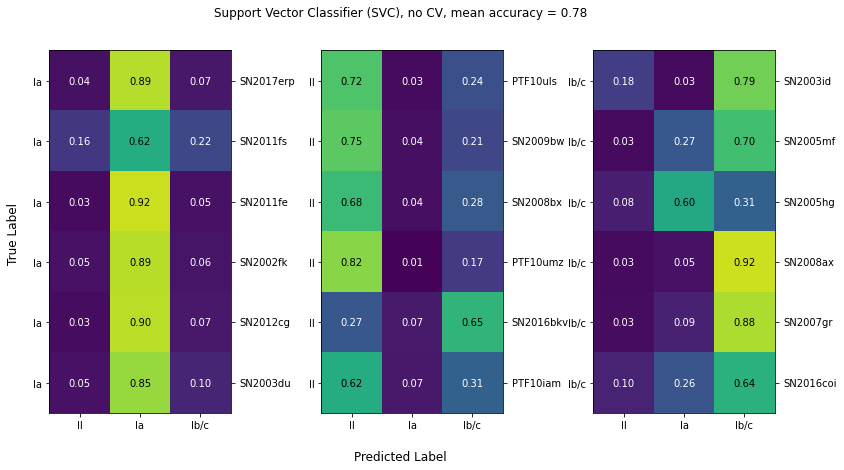

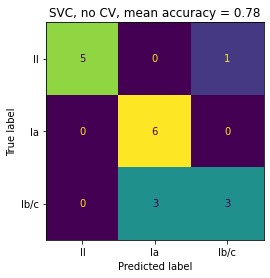

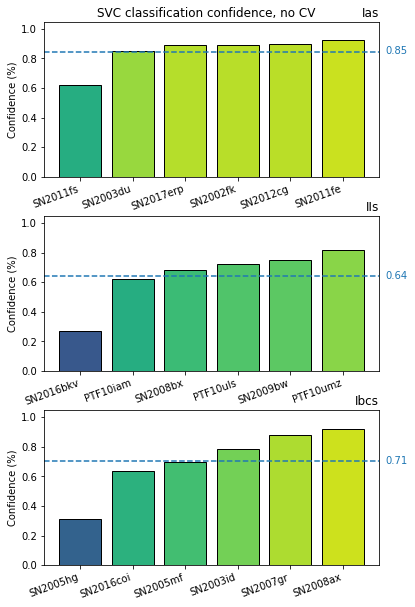

In [18]:
# 3. Visualise the model, using `visualise_clf()`
visualise_clf(svm_clf, CV=False)

In [19]:
# 4. Perform `GridSearchCV()` in order to tune the hyperparameters.
param_grid_svm = [
  {'C': [0.01,0.05,0.1,0.12,0.15,0.2,0.25], 
   'gamma': ['scale', 'auto',1,2, 0.1,0.2, 0.01,0.02], 
   'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
   'tol':[1e-4,1e-3,1e-2],
   'degree':[2,3,4],
   'coef0':[0,0.5,1],
   'probability':[True]
  }]

optimal_params_svm = GridSearchCV(
        SVC(), 
        param_grid_svm,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )

t0=time.time()
optimal_params_svm.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 6048 candidates, totalling 30240 fits
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=scale, kernel=r

[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, g

[CV] END C=0.01, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, 

[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[

[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01,

[CV] END C=0.01, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=1,

[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gam

[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.0

[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] 

[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma

[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, 

[CV] END C=0.01, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] E

[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time

[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0

[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, co

[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=

[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[C

[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.0001; 

[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s

[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, c

[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; t

[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END

[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.4s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.3s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; to

[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gam

[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0

[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01

[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total t

[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01,

[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C

[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.0

[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma

[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV

[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, 

[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=2, kernel

[CV] END C=0.01, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01

[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s


[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, 

[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.

[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.01, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma

[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0

[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.01, coef0=

[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total t

[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05,

[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=2, kernel=r

[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, 

[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0

[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0

[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total tim

[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=

[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV]

[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, de

[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] E

[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05

[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma

[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0,

[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, 

[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C

[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   

[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] 

[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END 

[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0

[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001

[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time= 

[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total t

[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=

[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef

[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=  

[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0

[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; 

[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degre

[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.2s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.3s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=

[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, 

[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=0.5, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.01; 

[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, 

[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=

[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, 

[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0

[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, deg

[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=2, ker

[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gam

[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END

[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.4s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.3s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] E

[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma

[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degr

[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.05, coef0=1, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0

[CV] END C=0.1, coef0=0, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, deg

[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=2, kernel=rbf, probabilit

[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, de

[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END

[CV] END C=0.1, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=1, ker

[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, de

[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, d

[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.2s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1

[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[

[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.4s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.4s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.4s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=2, kernel

[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, d

[CV] END C=0.1, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0, degr

[CV] END C=0.1, coef0=0.5, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[C

[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0

[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0

[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.

[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0

[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.

[CV] END C=0.1, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0

[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, 

[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total 

[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s

[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0

[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=2, 

[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] E

[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] EN

[CV] END C=0.1, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1,

[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=2, kernel=li

[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degre

[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s


[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1,

[CV] END C=0.1, coef0=1, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=1, ker

[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, de

[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, d

[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] 

[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=1, kernel

[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.1, kerne

[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.1, coef0=1, degree=4, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END 

[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time

[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0

[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, ga

[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END

[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, 

[CV] END C=0.12, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END 

[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=2, kernel

[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0

[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, 

[CV] END C=0.12, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, 

[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.7s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.3s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma

[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12

[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, 

[CV] END C=0.12, coef0=0.5, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[

[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, co

[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[

[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.001; total tim

[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=scale, kernel=linear, probability=True, 

[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, d

[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV]

[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; t

[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s

[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.6s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.3s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.3s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.2s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total 

[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, de

[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.2s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.2s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.9s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=

[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; to

[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol

[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.01; to

[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=2, kernel=rbf

[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, co

[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s


[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END

[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=1, kernel=

[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=2, kernel

[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, deg

[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef

[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.4s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.8s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.2s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.5s
[CV] END C=0.12, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] 

[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma

[CV] END C=0.12, coef0=1, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degr

[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, coef0=1, 

[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.12, coef0=1, degree=4, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.12, 

[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef

[CV] END C=0.15, coef0=0, degree=2, gamma=2, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degre

[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C

[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] E

[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=1, kerne

[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degr

[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=3, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree

[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[C

[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=1,

[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.7s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.2s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma

[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV

[CV] END C=0.15, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] E

[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] EN

[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef

[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.001; total

[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[

[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] 

[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef

[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; t

[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time= 

[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.3s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; to

[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; tota

[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=

[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total t

[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=0.5, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C

[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV

[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2,

[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=2, gamma=0.01, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=

[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s


[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=1

[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma

[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=3, gamma=0.01, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] 

[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=scale, kernel=linear, probability=True, tol=0.01; total tim

[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=

[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=2, kernel=r

[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, deg

[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15, coef0=1, degree=4, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.15

[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END 

[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamm

[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0

[CV] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2,

[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2,

[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] 

[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma

[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degre

[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s

[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.2s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2

[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] E

[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.3s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.3s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=2, kernel

[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=

[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0

[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[C

[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, 

[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef

[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=2, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001

[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[

[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamm

[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=

[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0

[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.3s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.2s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.2s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0

[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degre

[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s


[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; to

[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0

[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=1, kernel=po

[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C

[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=2, ga

[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2,

[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=1, 

[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END 

[CV] END C=0.2, coef0=1, degree=3, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=3, gamma=0.02, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degr

[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.6s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.4s
[CV] END C=0.2, coef0=1, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2

[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4

[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.1s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=2, kernel=poly, pr

[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree

[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, degree=4, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.2, coef0=1, d

[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[

[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s

[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=2, kernel=r

[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END

[CV] END C=0.25, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.01, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=2, gamma=0.02, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] E

[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[

[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=1, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gam

[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=2

[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, 

[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=3, gamma=0.02, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[

[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.01; total time=   0.1s
[CV] END C

[CV] END C=0.25, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree

[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.7s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.3s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma

[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0, degree=4, gamma=0.2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0,

[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=scale, kernel=rbf, probability=True, tol=0.001; total time=   0

[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=1, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25

[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=2, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, d

[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=  

[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=2, gamma=0.02, kernel=linear, probability=True, tol=0.01; 

[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=scale, kernel=poly, probability=True, tol=0.001; total 

[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=auto, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.0001; tota

[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, 

[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total 

[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=3, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.

[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.3s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.2s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=scale, kernel=poly, probability=True, tol=0.001; total 

[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=1, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=

[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=  

[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=0.5, degree=4, gamma=0.01, kernel=sigmoid, probability=True,

[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=scale, kernel=sigmoid, probability=True, tol=0.001

[CV] END C=0.25, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, ga

[CV] END C=0.25, coef0=1, degree=2, gamma=0.1, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.2, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, deg

[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=2, gamma=0.01, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1

[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=scale, kernel=linear, probability=True, tol=0.0001; total time=   0.0s
[CV] END

[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=1, kernel=rbf, pr

[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma

[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.2, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.2

[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=3, gamma=0.02, kernel=sigmoid, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coe

[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=linear, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=auto, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0

[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.1s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.2s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.0001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.1s
[CV] END C=0.25, coef0=1, degree=4, gamma=2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma

[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.2, kernel=poly, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree

[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.001; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s
[CV] END C=0.25, coef0=1, degree=4, gamma=0.02, kernel=sigmoid, probability=True, tol=0.01; total time=   0.0s

 Finished in 216.94 seconds.


In [78]:
# 5. Instantiate and train the optimised model.
svm1_clf = optimal_params_svm.best_estimator_ # instantiate
svm1_clf.fit(X_train,y_train)             # train

SVC(C=0.2, coef0=0, degree=4, gamma=0.1, kernel='poly', probability=True,
    tol=0.0001)

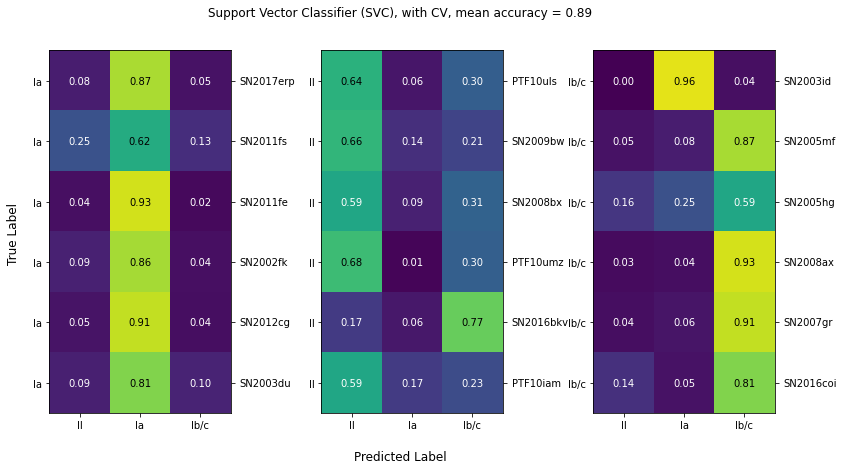

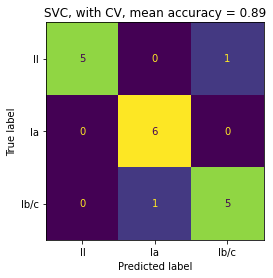

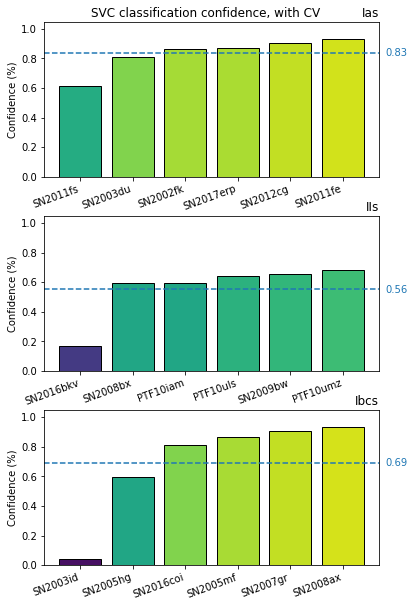

In [79]:
# 6. Visualise the optimised model, using `visualise_clf()`.
visualise_clf(svm1_clf, CV=True)

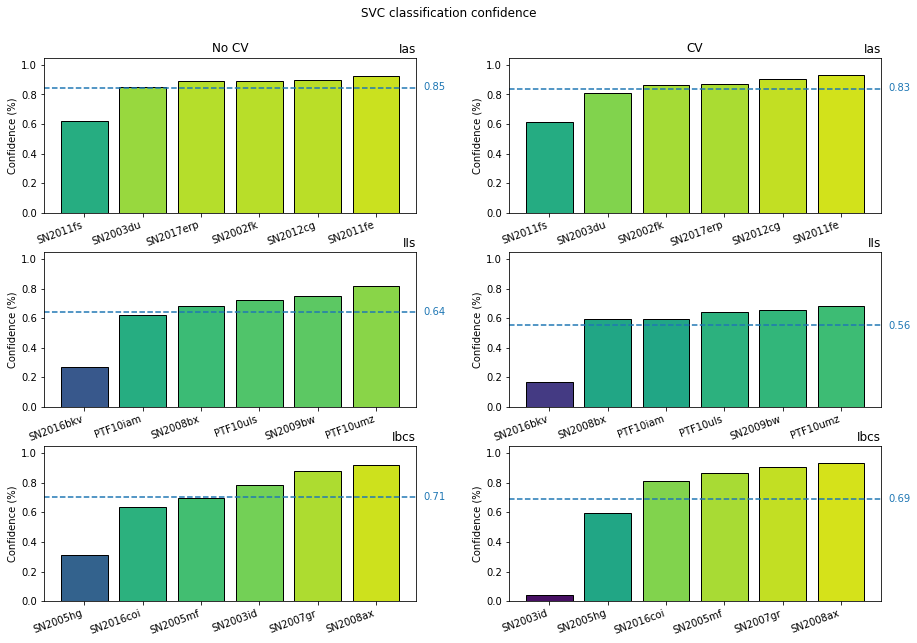

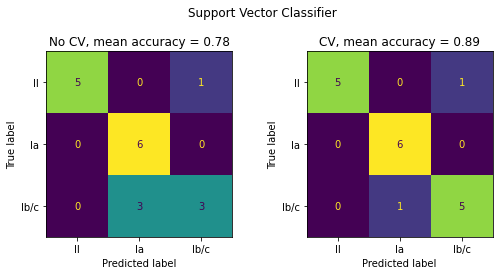

In [80]:
# 7. Compare the first ("straight out of the box") model and the optimised model.
compare_cv(svm_clf,svm1_clf)

# Random Forest Classifier (RF)

Random Forests are a type of ensemble classifier that uses a group (or a "forest") of decision trees, where each tree has been trained on a bootstrapped sample of the training data, and a random subset of features of the data are considered when splitting each node of the tree. 

In this case, each tree of the forest will consider a random selection of LCs from the entire training set as the bootstrapped sample, and since the LCs have been interpolated to a grid of 200 points, the "features" are the values of the LCs at the different grid points, so, as opposed to considering the LC over the entire grid of points in order to split a node, each tree will only consider a random sample of points.

This randomness is introduced to decrease the variance of the classifier and to prevent overfitting. The ultimate prediction of the RF is the average prediction of each individual tree.

### Links:
-  [Sklearn user guide](https://scikit-learn.org/stable/modules/ensemble.html#forest) for RFs.
-  RF [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).
-  [Breiman 2001](https://link.springer.com/content/pdf/10.1023/A:1010933404324.pdf), *Random Forests*.

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rfc_clf = RandomForestClassifier()
rfc_clf.fit(X_train, y_train)

RandomForestClassifier()

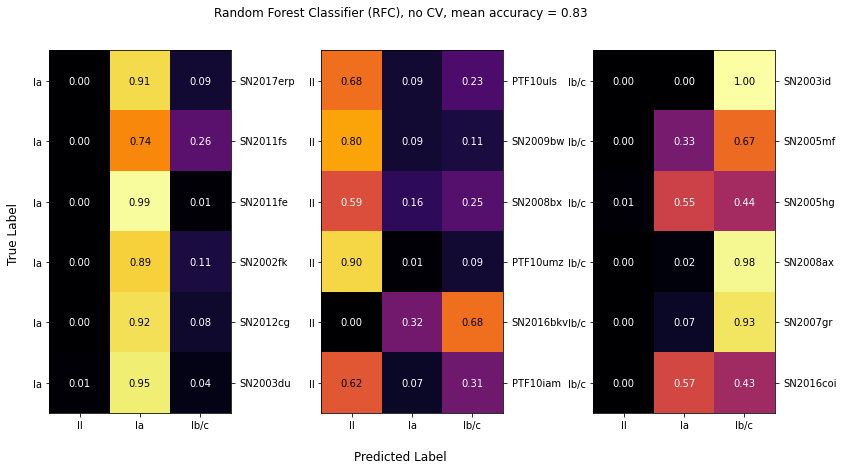

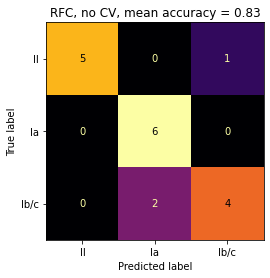

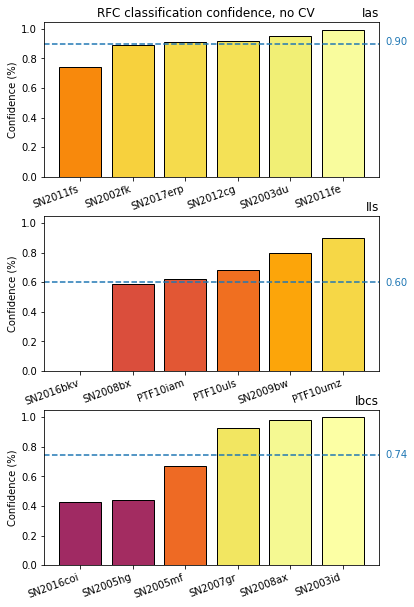

In [26]:
visualise_clf(rfc_clf, CV=False, save=True)

In [27]:
param_grid_rfc = [
  {'n_estimators': [20,30,40],
   'criterion': ['gini', 'entropy'], 
   'ccp_alpha': [0.0,0.01,0.1,0.001],
   'max_features':['auto', 'log2'],
   'max_depth': [None,1,2,3,4,5]},
]
optimal_params_rfc =  GridSearchCV(
        RandomForestClassifier(), 
        param_grid_rfc,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )
t0=time.time()
optimal_params_rfc.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_dept

[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=2, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, crit

[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=5, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, crit

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=log2, n_estimators=40; total time=   0.0s
[

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=log2, n_estimators=20; total time=   0.0s
[

[CV] END ccp_alpha=0.01, criterion=gini, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=1, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=1, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=1, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=gini, max_depth=1, max_features=auto, n_estimators=20; total time=   0.0s
[CV]

[CV] END ccp_alpha=0.01, criterion=gini, max_depth=5, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=None, max_features=auto, n_estim

[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=2, max_features=log2, n_estimators=30; total time=

[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=4, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=4, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=4, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=5, max_features=auto, n_estimators=30; total time=

[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=1, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, crit

[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, crit

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=log2, n_estimato

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=log2, n_estimators=20; total time=   0.0s
[

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=5, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=5, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=5, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=5, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=5, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=5, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=5, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=None, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=None, max_features=auto, n_estimators=20; total time=   0.

[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=2, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END c

[CV] END ccp_alpha=0.001, criterion=gini, max_depth=4, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=4, max_features=log2, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=5, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=5, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=gini, max_depth=5, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END c

[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=auto, n_estimators=40; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=log2, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=log2, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=1, max_features=log2, n_estimators=30; to

[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=20; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=30; total time=   0.0s
[CV] END ccp_alpha=0.001, criterion=entropy, max_depth=4, max_features=auto, n_estimators=30; to

In [28]:
rfc_clf1 = optimal_params_rfc.best_estimator_
rfc_clf1.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       max_features='log2', n_estimators=40)

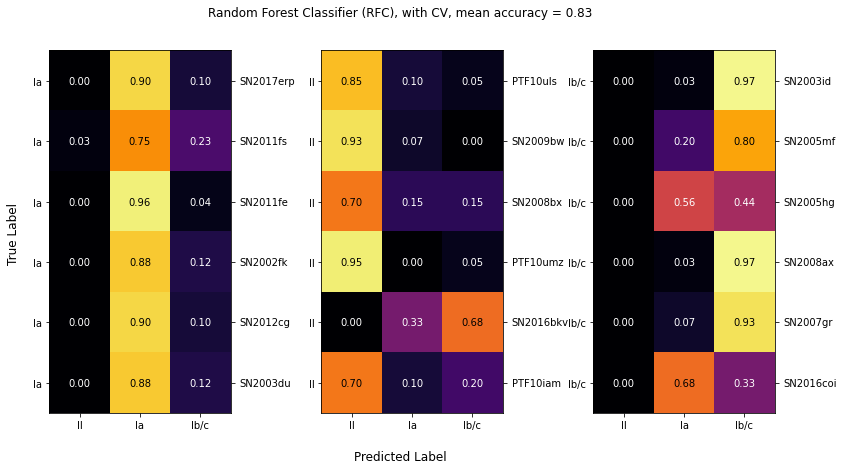

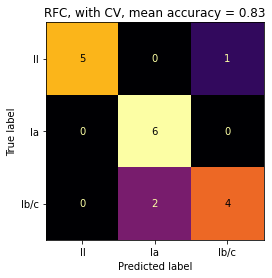

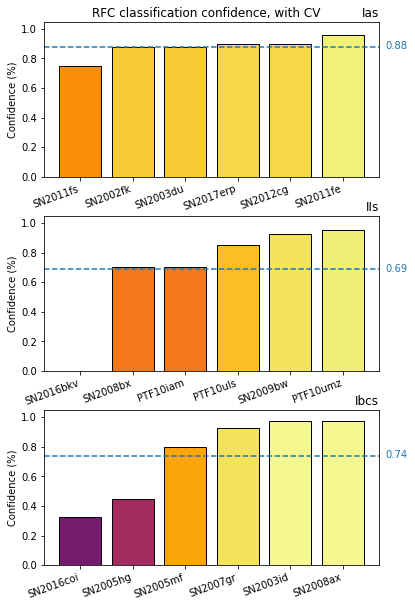

In [29]:
visualise_clf(rfc_clf1, CV=True)

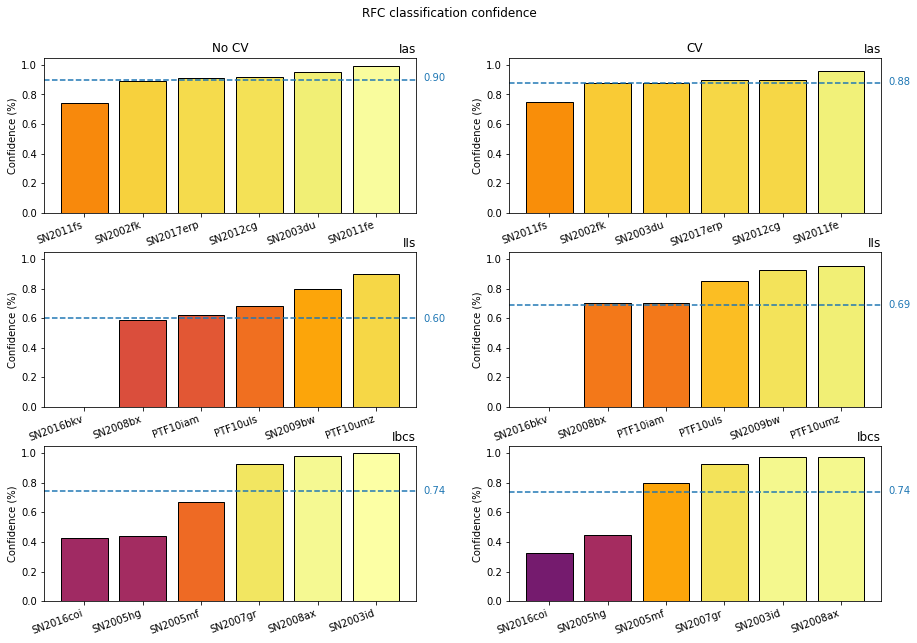

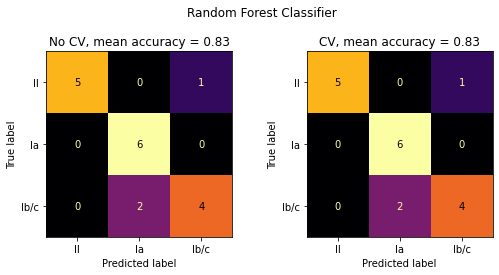

In [30]:
compare_cv(rfc_clf, rfc_clf1)

# K-Nearest Neighbours (KNN)
KNN classifies a sample based on the classification of its neighbours in parameter space. The sample is assigned the label of the majority its $k$ nearest neighbours, where $k$ is a positive integer. For example, if $k=4$, then, if three of the sample's nearest neighbours are type Ias, and one is a type II, then the sample will be labeled as a type Ia.
### Links:
- [Sklearn user guide](https://scikit-learn.org/stable/modules/neighbors.html#classification).
- KNN [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

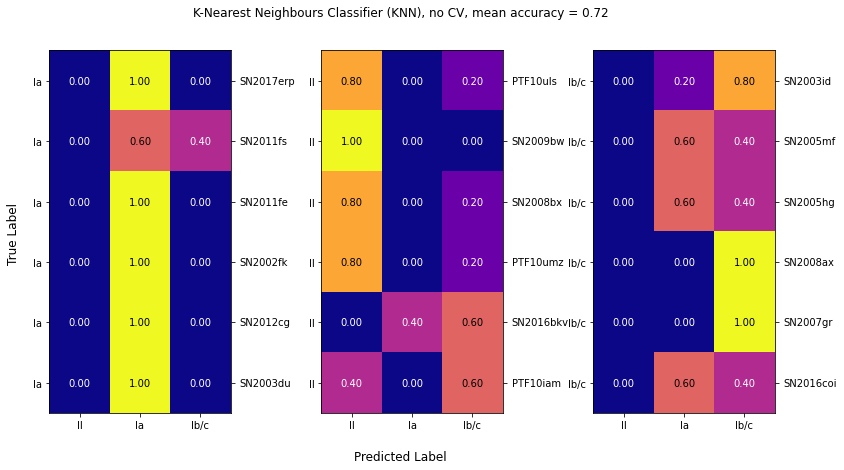

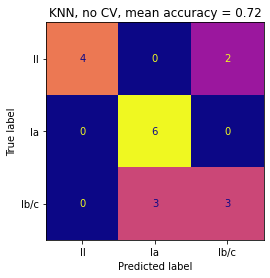

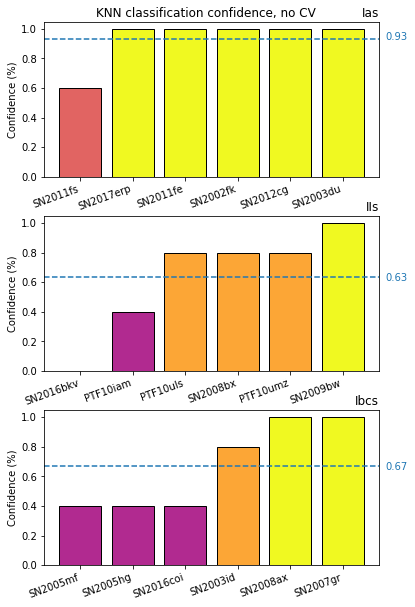

In [31]:
visualise_clf(knn_clf, CV=False)

In [32]:
param_grid_knn = [
  {'n_neighbors': [1,2,3,4,5,6],
    'weights': ['uniform', 'distance'], 
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[1,2,3,4,6,7,8],
    'p': [1,2,3]
}
]
optimal_params_knn = GridSearchCV(
        KNeighborsClassifier(), 
        param_grid_knn,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )
t0=time.time()
optimal_params_knn.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1

[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=1, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=2, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=3, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=4, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=6, n_neighbors=4, p=1, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=8, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=1, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=2, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=2, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=2, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=3, n_neighbors=6, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=4, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=6, n_neighbors=6, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=2, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=8, n_neighbors=6, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=1, n_neig

[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=2, n_neig

[CV] END algorithm=brute, leaf_size=3, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neig

[CV] END algorithm=brute, leaf_size=3, n_neighbors=5, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=5, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=3, n_neig

[CV] END algorithm=brute, leaf_size=4, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neighbors=4, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=4, n_neig

[CV] END algorithm=brute, leaf_size=6, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=2, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neig

[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neighbors=6, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=6, n_neig

[CV] END algorithm=brute, leaf_size=7, n_neighbors=4, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=4, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=7, n_neig

[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=3, p=3, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neig

In [33]:
knn1_clf = optimal_params_knn.best_estimator_
knn1_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=3, p=1,
                     weights='distance')

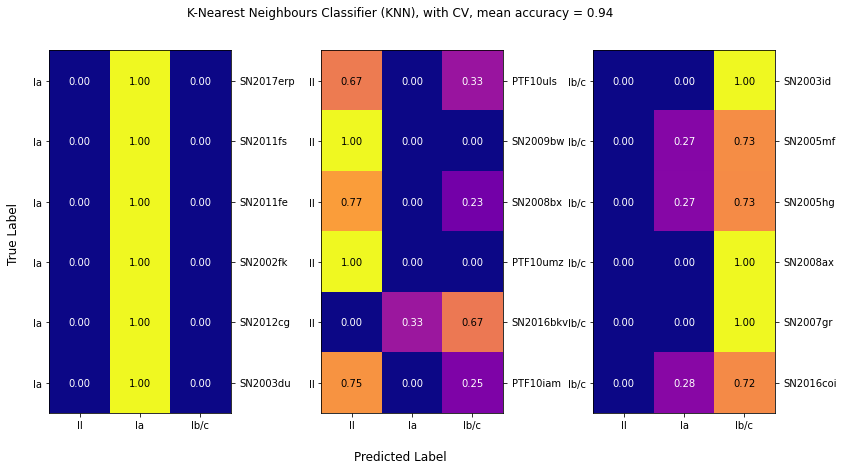

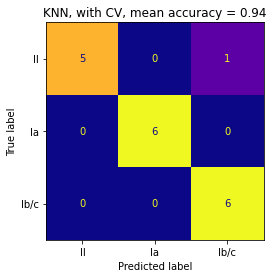

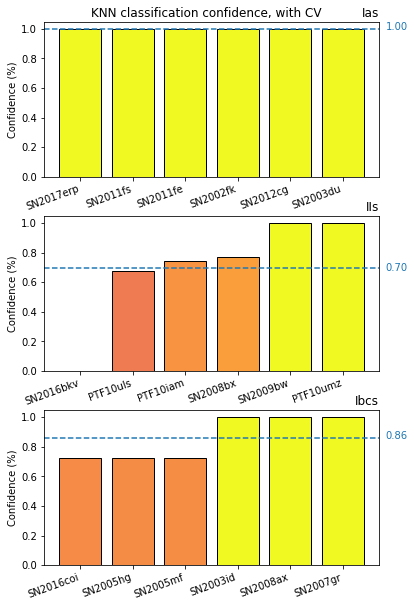

In [34]:
visualise_clf(knn1_clf, CV=True)

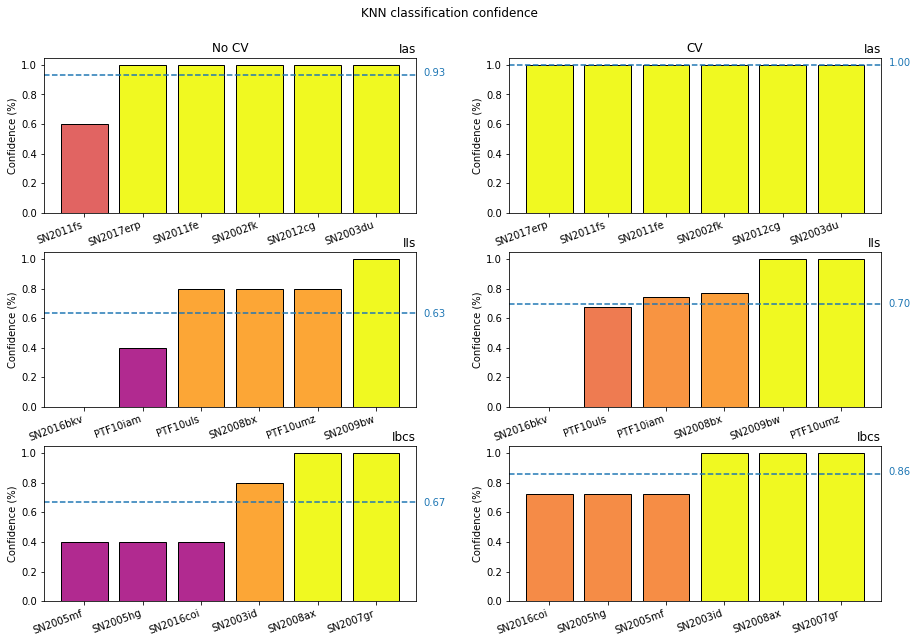

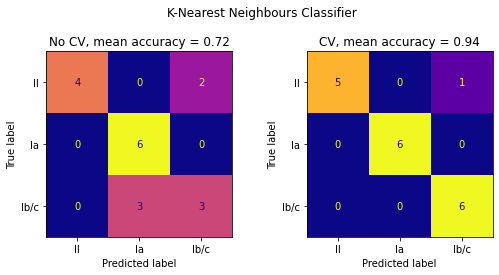

In [35]:
compare_cv(knn_clf,knn1_clf)

# Multi-Layered Perceptron Neural Network (MLP NN)
A MLP NN classifier is an interconnected network of neurons that, with the help of training data, learns a non-linear function in order to classify this training data, and subsequent testing data. The network consists of an input layer that simply represents the input, and an output layer, corresponding to the "decision" of the network. Between the input and output layers, there may be what are known as "hidden layers," which will act to distinguish between the input data further. 

In this case, the input layer consists of 200 neurons, with neuron $i\ (i=0,1,2,\ldots,199)$ representing the value of the light curve at the $i$th interpolated point, and the output layer consists of 3 neurons and represents the classification of the SN, based on the light curve. The activation of the ouput neurons corresponds to the probability that the SN is a given type. The number and size of the hidden layers is a hyperparameter. In this example, not many different permutations of hidden layers are examined, as the process of cross validation for this model takes a long time, however this may be explored further.

This is only one type of neural network. There exists many different types, such as convolutional NNs, auto-encoder NNs, and recurrent NNs, to name a few. They use different processes and network structures in order to carry out their function. Sklearn does not explore these types. The Python packages Keras and Tensorflow are available to develop these NNs, however, these packages were not used in this project.

### Links:
- [Sklearn User Guide](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
- [MLP NN documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
- [Machine Learning for Physicists](https://machine-learning-for-physicists.org/)
    - This lecture series is given by Dr. Florian Marquardt of the University of Erlangen-Nuremberg, and explores the diverse field of neural networks and deep learning, the mathematical formulation, and their applications. It also provides useful examples. 
    - It is highly recommended if a deeper understanding of NNs is desired.

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train,y_train)

MLPClassifier()

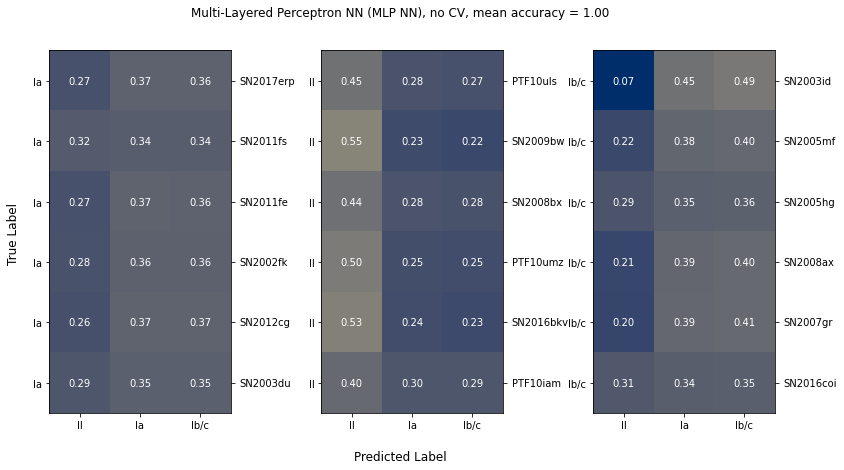

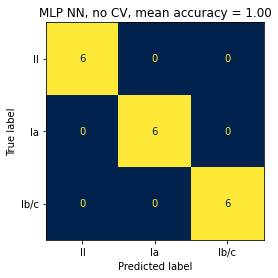

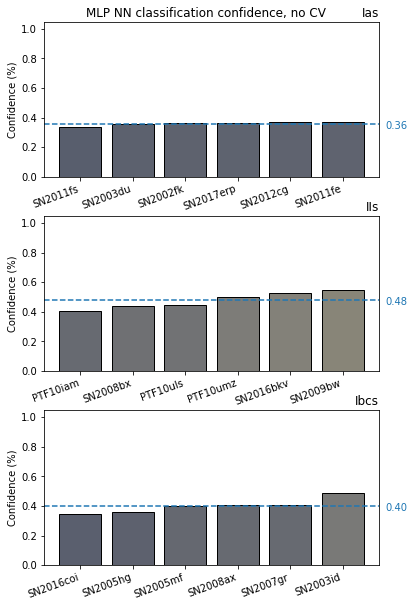

In [38]:
visualise_clf(mlp_clf, CV=False)

In [39]:
param_grid_mlp = [
  {'hidden_layer_sizes': [(100,), (100,100), (100,50), (100,75,50)],
   'activation':['identity', 'logistic', 'tanh', 'relu'],
   'solver':['lbfgs','sgd','adam'],
   'max_iter':[600,800,1000]
  }
]
optimal_params_mlp = GridSearchCV(
        MLPClassifier(), 
        param_grid_mlp,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )
t0=time.time()
optimal_params_mlp.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=lbfgs; total time=   1.6s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=lbfgs; total time=   1.5s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=lbfgs; total time=   2.8s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=lbfgs; total time=   2.3s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=lbfgs; total time=   0.5s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=sgd; total time=   0.6s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=sgd; total time=   0.5s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=sgd; total time=   0.5s
[CV] END activation=identity, hidden_layer_sizes=(100,), max_iter=600, solver=sgd; total time=   0.8s
[CV] END 

[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   5.6s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   1.7s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   2.3s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   3.5s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   2.3s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   2.1s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   1.8s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.8s
[CV] END activation=identity, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.8s
[CV] END activation=identity, h

[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=sgd; total time=   1.3s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=sgd; total time=   1.4s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=sgd; total time=   1.6s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=sgd; total time=   1.6s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=sgd; total time=   1.3s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=adam; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=adam; total time=   0.3s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=adam; total time=   0.4s
[CV] END activation=identity, hidden_layer_sizes=(100, 75, 50), max_iter=800, solver=adam; total time=   0.0s
[CV] END activa

[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=600, solver=sgd; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=600, solver=sgd; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=600, solver=adam; total time=   1.3s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=600, solver=adam; total time=   1.3s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=600, solver=adam; total time=   1.3s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=600, solver=adam; total time=   1.4s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=600, solver=adam; total time=   1.4s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=800, solver=lbfgs; total time=   5.0s
[CV] END activation=logistic, hidden_layer_sizes=(100, 100), max_iter=800, solver=lbfgs; total time=   5.3s
[CV] END activation=logistic, hidden_

[CV] END activation=logistic, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   1.5s
[CV] END activation=logistic, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   1.6s
[CV] END activation=logistic, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   1.5s
[CV] END activation=logistic, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(100, 75, 50), max_iter=600, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(100, 75, 50), max_iter=600, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(100, 75, 50), max_iter=600, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(100, 75, 50), max_iter=600, solver=lbfgs; total time=   0.1s
[CV] END activation=l

[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=800, solver=adam; total time=   1.2s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=800, solver=adam; total time=   0.9s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=lbfgs; total time=   4.0s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=lbfgs; total time=   3.9s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=lbfgs; total time=   3.5s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=lbfgs; total time=   3.2s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=lbfgs; total time=   1.6s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=sgd; total time=   1.6s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100,), max_iter=1000, solver=sgd; total time=   1.4s


[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=lbfgs; total time=   4.4s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=sgd; total time=   1.4s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=sgd; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=sgd; total time=   1.2s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=sgd; total time=   1.4s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=sgd; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=800, solver=adam; tot

[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=600, solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=600, solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=600, solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=600, solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=600, solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=800, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=800, solver=lbfgs; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=800, solver=lbfgs; total time=   0.8s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=800, solver=lbfgs; total time=   1.0s
[CV] END activation=relu, hidden_layer_sizes=(100,), max_iter=800, solver=lbfgs; total time=   0.3s
[CV] 

[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=lbfgs; total time=   1.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=lbfgs; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=lbfgs; total time=   2.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=lbfgs; total time=   1.3s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=600, solver=adam; 

[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=adam; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=adam; total time=   0.6s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=adam; total time=   0.9s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(100, 75, 50), max_iter=1000, solver=adam; total time=   0.5s

 Finished in 1063.33 seconds.


In [40]:
mlp1_clf = optimal_params_mlp.best_estimator_
mlp1_clf.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=800, solver='lbfgs')

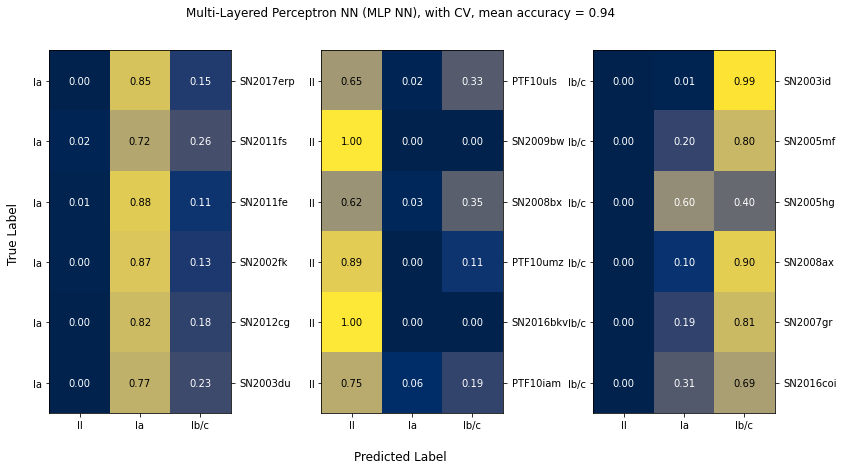

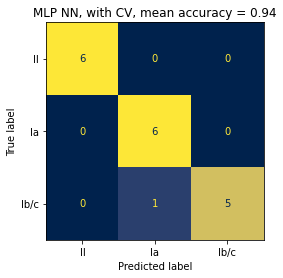

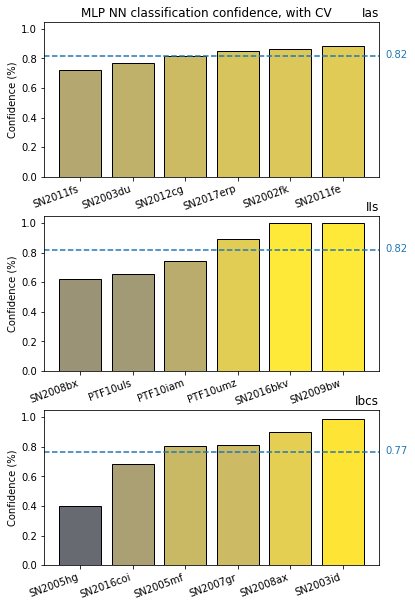

In [41]:
visualise_clf(mlp1_clf, CV=True)

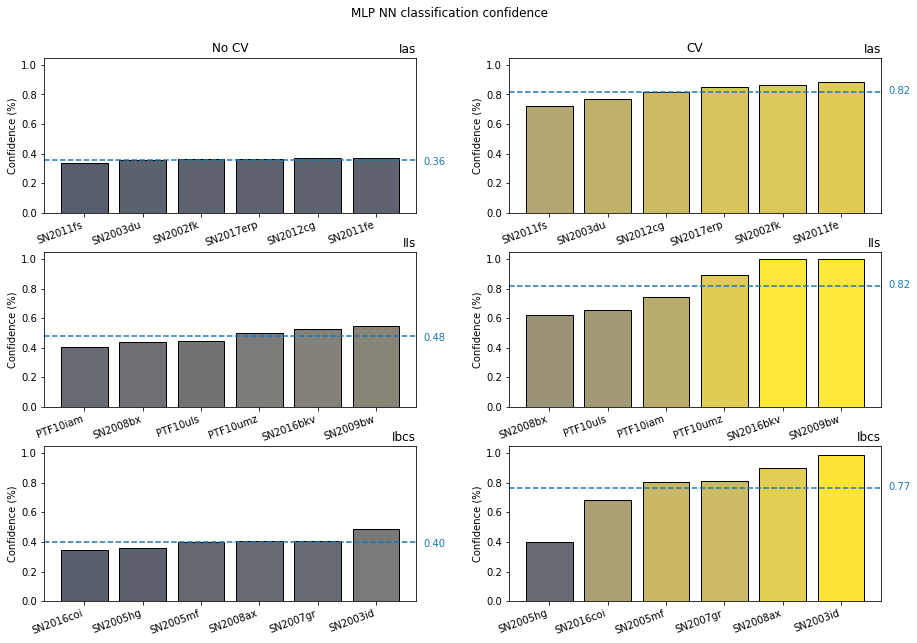

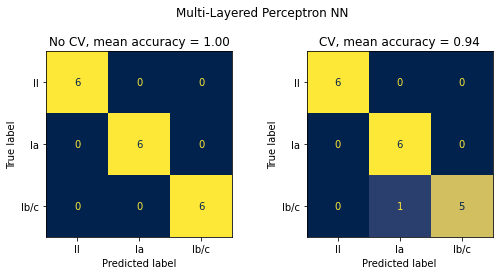

In [42]:
compare_cv(mlp_clf,mlp1_clf)

# Gaussian Processes (GP) classification

### Links:
- [Sklearn user guide](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process) for GP classification.
- GP classification [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html).

In [43]:
from sklearn.gaussian_process import GaussianProcessClassifier 
import sklearn.gaussian_process.kernels as skernels

In [44]:
kernel = skernels.RBF()

In [45]:
gpc_clf = GaussianProcessClassifier(kernel=kernel)
gpc_clf.fit(X_train, y_train)
# visualise_clf(gpc_clf, CV=False, normalise=norm)

GaussianProcessClassifier(kernel=RBF(length_scale=1))

In [46]:
param_grid_gpc = [
  {'kernel': [skernels.RBF(), skernels.Matern(), skernels.RationalQuadratic()],
   'max_iter_predict' : [100,200,300],
   'n_restarts_optimizer' : [0,1,2,3,4]
   }
]
optimal_params_gpc = GridSearchCV(
        GaussianProcessClassifier(), 
        param_grid_gpc,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )

t0=time.time()
optimal_params_gpc.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=0; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=0; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=0; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=0; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=0; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.0s
[CV] END kernel=RBF(length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.0s
[CV] END kernel=RBF(

[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.0s
[CV] END kernel=Matern(length_scale=1, nu=1.5), max_iter_predict=100, n_restarts_optimizer=3; to

[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.1s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.1s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.1s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.2s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=1; total time=   0.1s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.2s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.2s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=100, n_restarts_optimizer=2; total time=   0.2s


[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=300, n_restarts_optimizer=4; total time=   0.3s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=300, n_restarts_optimizer=4; total time=   0.3s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=300, n_restarts_optimizer=4; total time=   0.4s
[CV] END kernel=RationalQuadratic(alpha=1, length_scale=1), max_iter_predict=300, n_restarts_optimizer=4; total time=   0.5s

 Finished in 37.04 seconds.


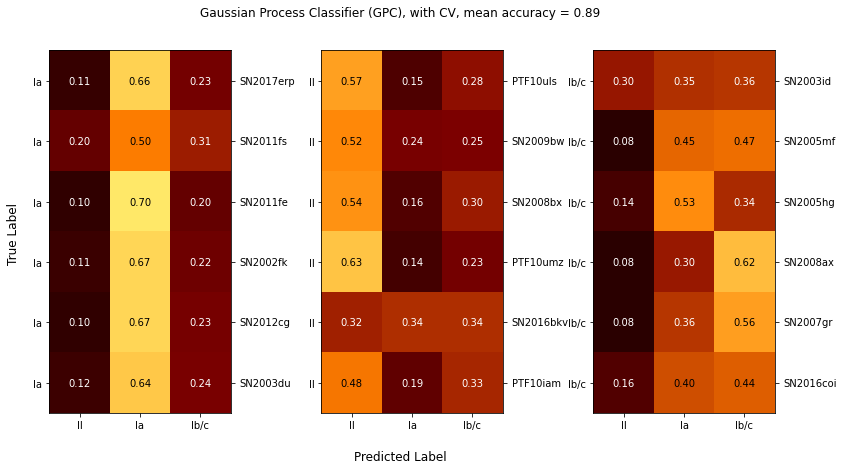

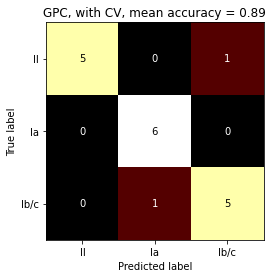

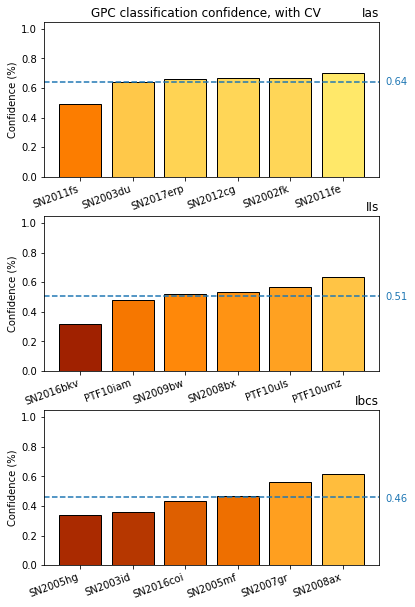

In [48]:
gpc1_clf = optimal_params_gpc.best_estimator_
gpc1_clf.fit(X_train,y_train)
visualise_clf(gpc1_clf, CV=True)

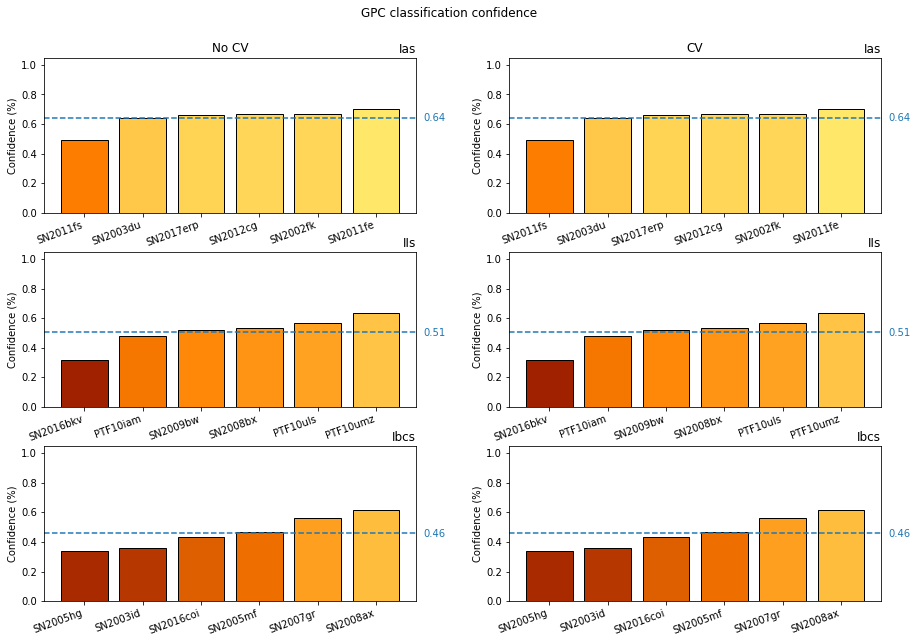

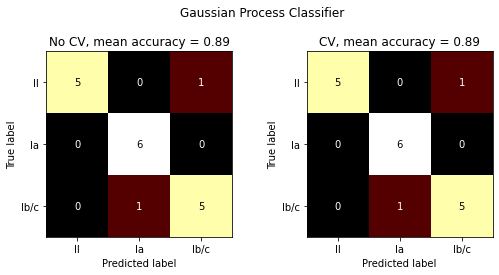

In [49]:
compare_cv(gpc_clf,gpc1_clf)

# Decision Tree (DT)
DTs classify data by examining each feature of the input data and testing which feature does the best job at separating the data into different classes. 

For example, consider the value of the LC at roughly $t\simeq 20$ days after max, which can be denoted $\mathbf{X}[t= 20]$, where $\mathbf{X}$ is the notation for the input. Here the Ia bumps occur, and the type II LCs are generally a greater value due to their plateau, (see [this figure](#Figure-of-Curves)). Here, the decision tree could, for example, say that "if $\mathbf{X}[t= 20] \gtrsim0.970$, then it is a type II, if not, then it is not a type II," and then from here link to new nodes, where other decisions will be made to further constrain the classification.

Due to the simple nature of the DT, sklearn provides a function to visualise them, namely `sklearn.tree.plot_tree`. This will be used in the following example to visualise the though process of the algorithm.

### Links:
- Decision Tree [user guide](https://scikit-learn.org/stable/modules/tree.html#tree).
- Decision tree [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [50]:
from sklearn.tree import DecisionTreeClassifier

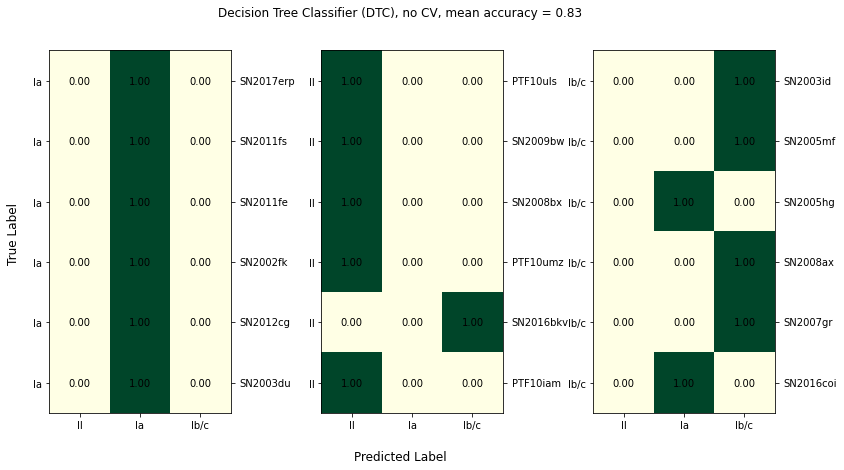

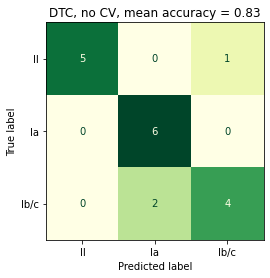

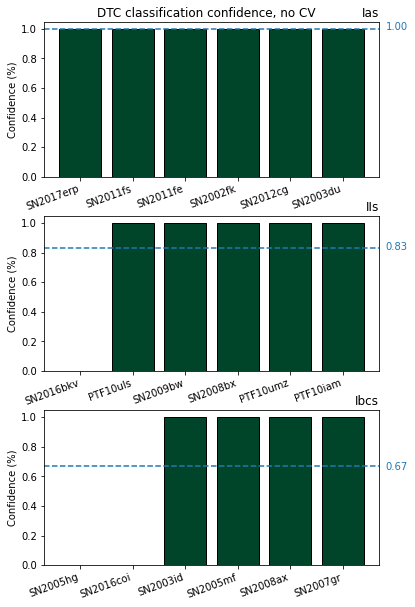

In [51]:
dtc_clf = DecisionTreeClassifier()
dtc_clf.fit(X_train, y_train)
visualise_clf(dtc_clf, CV=False)

In [52]:
from sklearn.tree import plot_tree

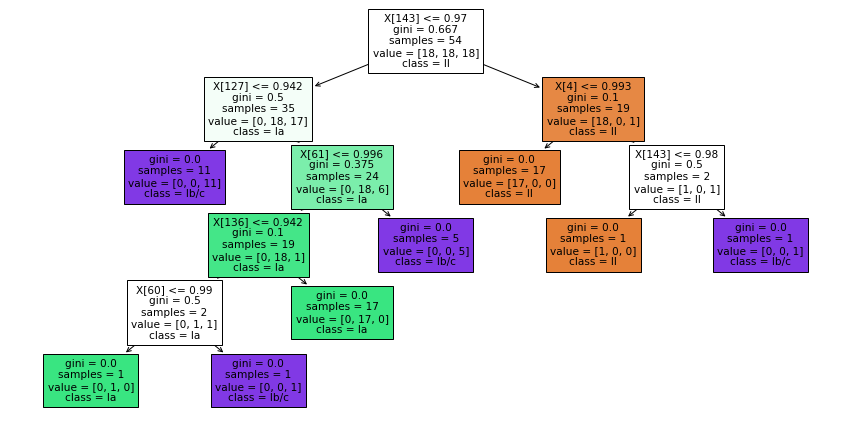

In [53]:
plt.figure(figsize=(15,7.5))
plot_tree(dtc_clf, class_names=['II', 'Ia', 'Ib/c'], filled=True)
plt.show()

In [54]:
param_grid_dtc = [
  {'criterion': ['gini','entropy'],
   'splitter' : ['best','random'],
   'max_depth': [None,1,2,3,4],
   'min_samples_split':[1,2,3,4],
   'min_samples_leaf':[1,2,3,4],
  }
]
optimal_params_dtc = GridSearchCV(
        DecisionTreeClassifier(), 
        param_grid_dtc,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )

t0=time.time()
optimal_params_dtc.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[C

[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=3, m

[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=

[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitte

[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2, splitter=

[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitte

[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=

[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=4, splitte

[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=3, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=

[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_s

[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, m

[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=1, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_s

[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, m

[CV] END criterion=entropy, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=1, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, m

[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, m

[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, m

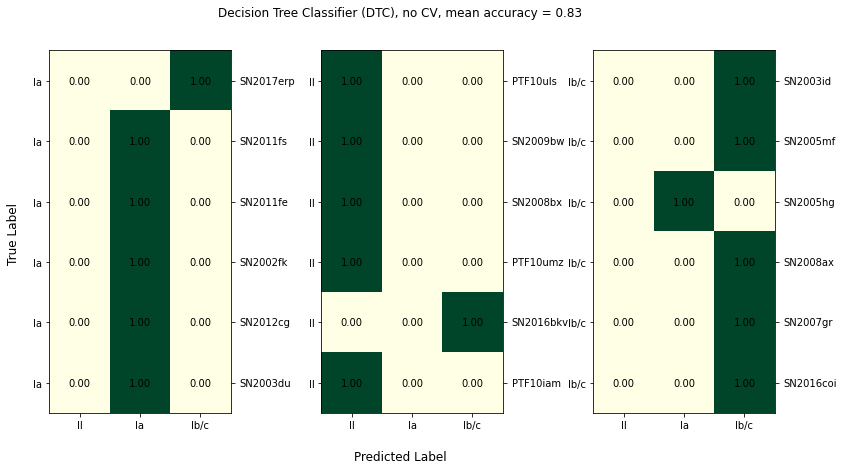

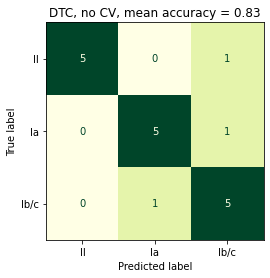

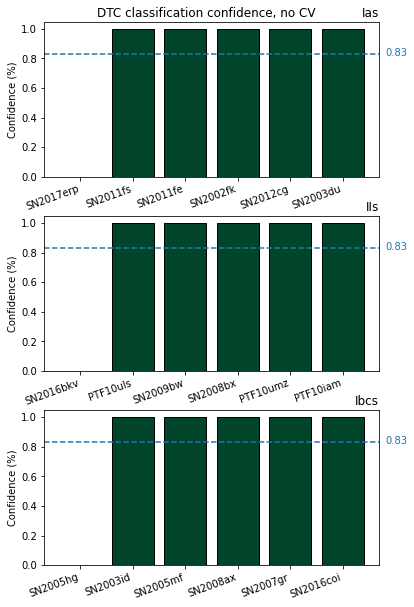

In [55]:
dtc1_clf = optimal_params_dtc.best_estimator_
dtc1_clf.fit(X_train, y_train)
visualise_clf(dtc1_clf, CV=False)

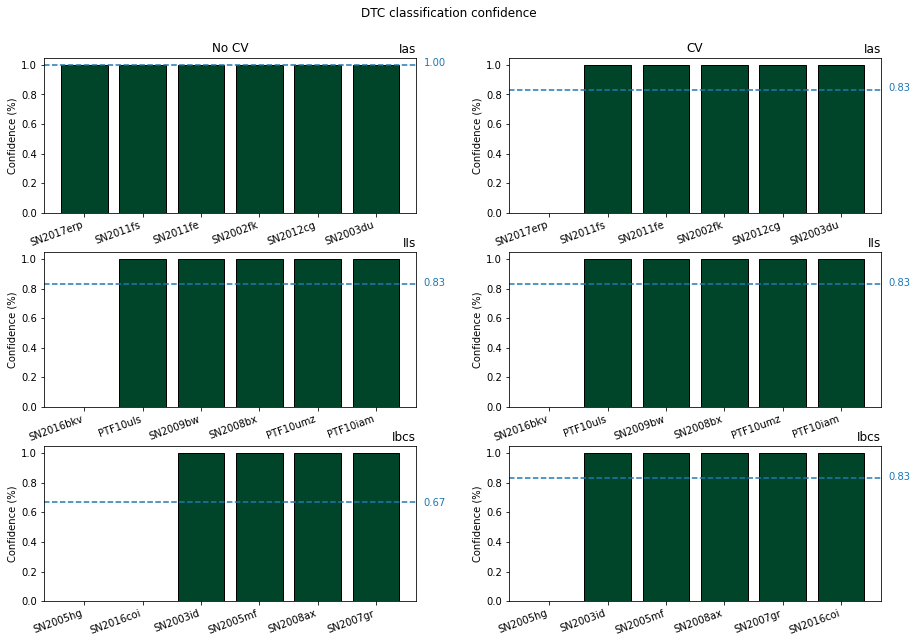

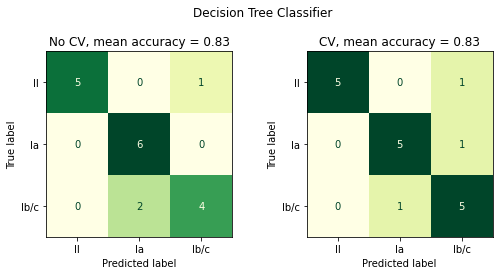

In [56]:
compare_cv(dtc_clf,dtc1_clf)

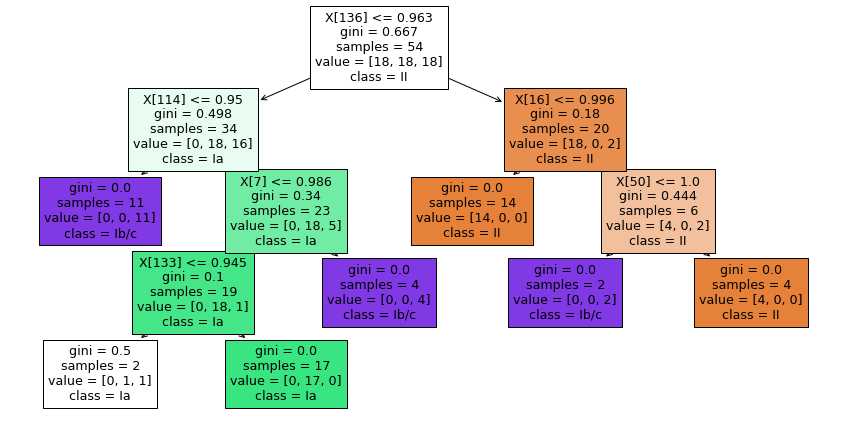

In [57]:
plt.figure(figsize=(15,7.5))
plot_tree(dtc1_clf, class_names=['II', 'Ia', 'Ib/c'], filled=True)
plt.show()

## Adaboost classifier
Adaboost (short for Adaptive Boosting) is similar to the RF classifier in that it uses an ensemble of classifiers. However, Adaboost uses an ensemble of *weak* learners that are only slightly better than a random guess. For example, these could be a decision trees with only one node (which are called "stumps"). Another way Adaboost differs from RF is that the final predition by the ensemble is a weighted sum of the predictions of the weak learners (for a RF, each tree has an equal contribution in the final decision.)
### Links:
- Adaboost [user guide]()
- Adaboost [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier).

In [58]:
from sklearn.ensemble import AdaBoostClassifier

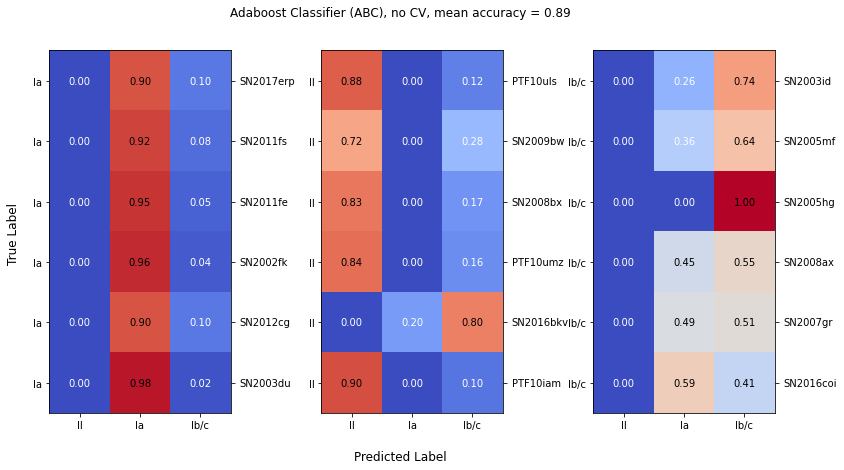

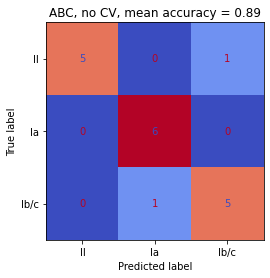

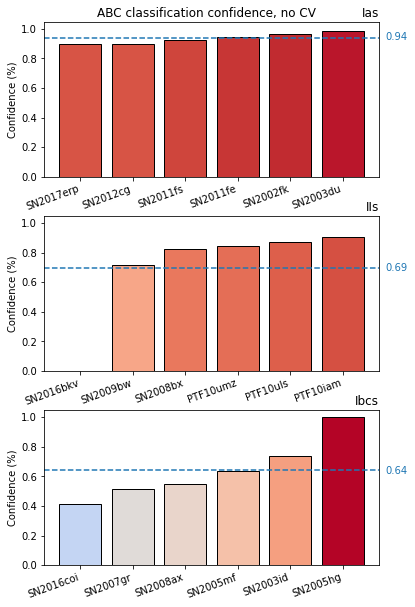

In [59]:
abc_clf = AdaBoostClassifier()
abc_clf.fit(X_train,y_train)
visualise_clf(abc_clf, CV=False)

In [60]:
param_grid_abc = [
  {'n_estimators': [5,10,20,30,40,50,70],
   'learning_rate' : [0.1,0.15,0.175,0.2,0.215,0.25,0.275,0.3,0.35,0.375,0.4,0.45,1],
   'algorithm' : ['SAMME', 'SAMME.R']
  }
]
optimal_params_abc = GridSearchCV(
        AdaBoostClassifier(), 
        param_grid_abc,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )

t0=time.time()
optimal_params_abc.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 182 candidates, totalling 910 fits
[CV] END .algorithm=SAMME, learning_rate=0.1, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.1, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.1, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.1, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.1, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.1, n

[CV] END algorithm=SAMME, learning_rate=0.175, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.175, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.175, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.175, n_estimators=70; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.2, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.2, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.2, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.2, n_estimators=5; total time=   0.0s
[CV] END .algorithm=SAMME, learning_rate=0.2, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.2, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.2, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.2, n_estimators=10; total time=   0.0s
[CV] END algorithm=S

[CV] END algorithm=SAMME, learning_rate=0.25, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.25, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.25, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.25, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.25, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.25, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.25, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.275, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.275, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.275, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.275, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.275, n_estimators=5; total time=   0.0s
[CV] END algorit

[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.35, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.375, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.375, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.375, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.375, n_estimators=5; total time=   0.0s
[CV] END algorit

[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME, learning_rate=0.45, n_estimators=70; total time=   0.0s
[CV] END ...algorithm=SAMME, learning_rate=1, n_estimators=5; total time=   0.0s
[CV] END ...algor

[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=70; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.15, n_estimators=70; total time=

[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=40; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.215, n_estimators=50;

[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.3, n_estimators=30; total time=   0.0s
[CV]

[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=20; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=30; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.4, n_estimators=30; total time=   0.0s
[CV]

In [61]:
abc1_clf = optimal_params_abc.best_estimator_
abc1_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.15)

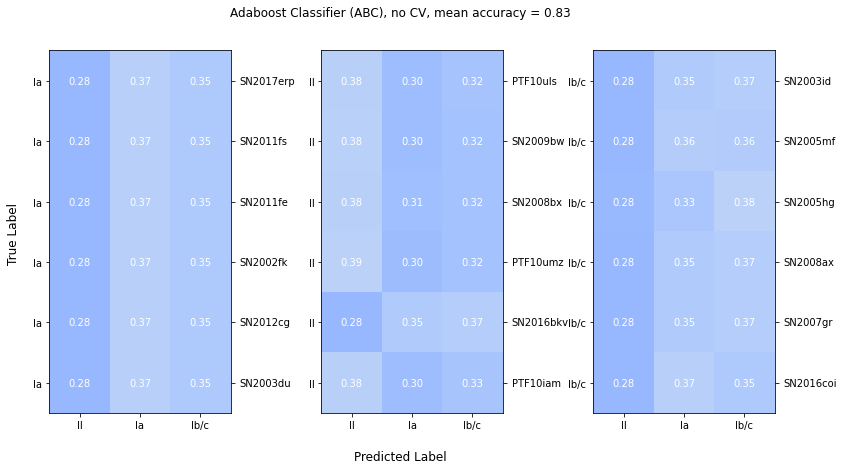

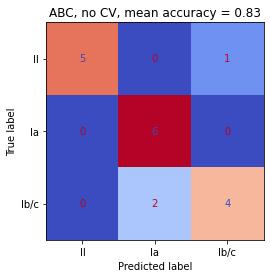

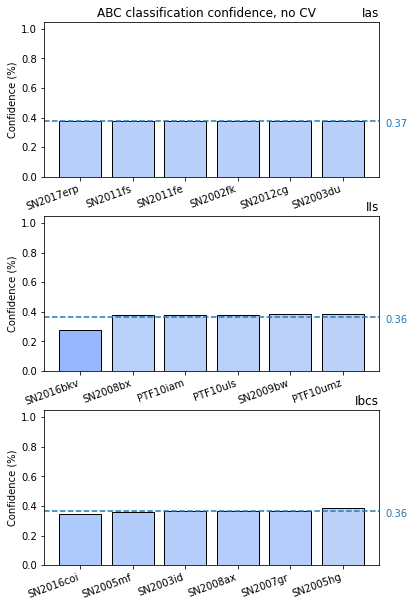

In [62]:
visualise_clf(abc1_clf, CV=False)

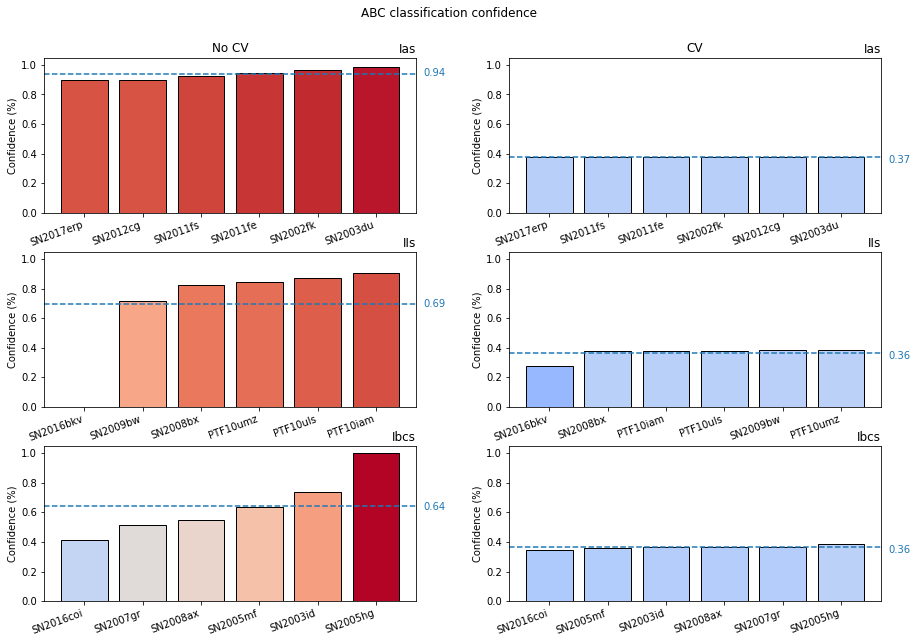

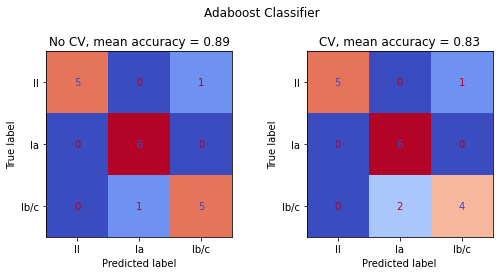

In [63]:
compare_cv(abc_clf,abc1_clf)

## Gaussian Naive Bayes (GNB)
Naive Bayes classifies data using Bayes theorem. GNB assumes that each feature within each class is normally distributed, and so computes the mean and standard deviation of each feature. When classifying test data, the GNB model considers each feature of the LC and calculates the likelihood that the LC has the value it does at each interpolated point given that it is either a Ia, II, or Ib/c.

For example, if the test LC is $\mathbf{X}$, then, if $y$ is the output ($y=\{$Ia, II, Ib/c$\}$), 

$$P(y\ |\ \mathbf{X}[0],\ \mathbf{X}[1],\ \ldots\ ,\ \mathbf{X}[200])\propto P(y) \prod\limits_{i=0}^{200} P(\mathbf{X}[i]\ |\ y).$$

That is, the probability that this LC is a certain type of SN, given the values of the LC at each point, is proportional to the probability that it is that type ($=1/3$, because there are the same numebr of Ias, IIs, and Ib/cs in the training set) times the product of the probabilities of each value of the LC being that value given it is that type of SN.
### Links:
- GNB [user guide](https://scikit-learn.org/stable/modules/naive_bayes.html)
- GNB [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [Majumder, P.](https://iq.opengenus.org/gaussian-naive-bayes/), *Gaussian Naive Bayes* (article).

In [64]:
from sklearn.naive_bayes import GaussianNB

In [65]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB()

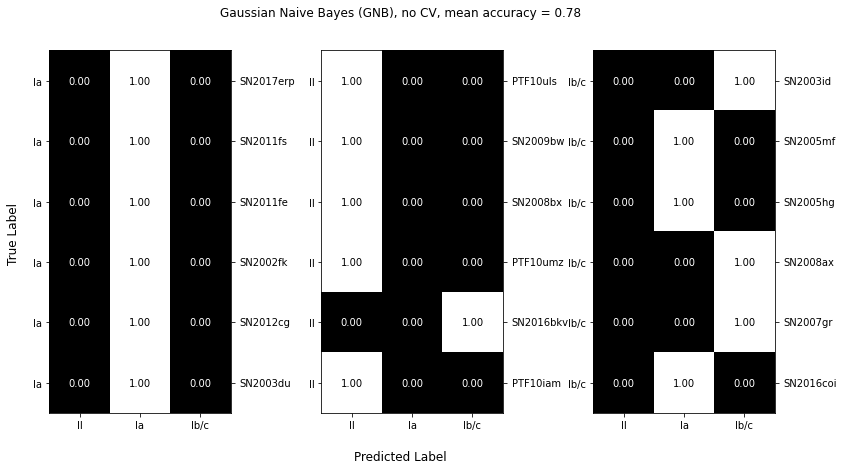

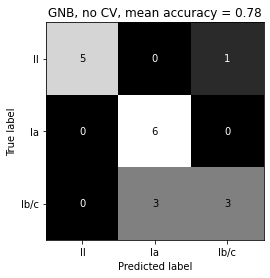

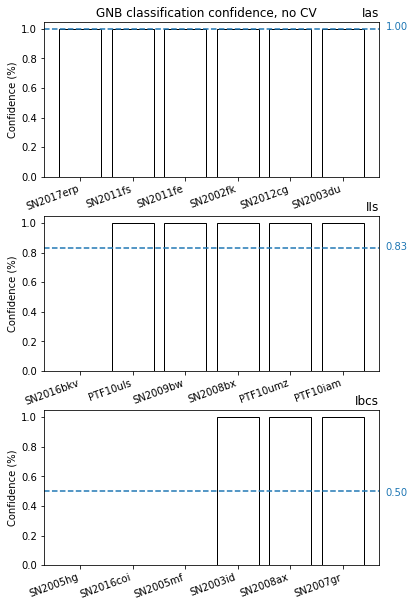

In [66]:
visualise_clf(gnb_clf, CV=False)

In [67]:
param_grid_gnb = [
  {'var_smoothing': [1e-11,1e-12,1e-10,1e-9,1e-8,1e-7,1e-6]
  }
]
optimal_params_gnb = GridSearchCV(
        GaussianNB(), 
        param_grid_gnb,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )

t0=time.time()
optimal_params_gnb.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-10; total time=   0.0s
[CV] END ................................var_smoo

In [68]:
gnb1_clf = optimal_params_gnb.best_estimator_
gnb1_clf.fit(X_train, y_train)

GaussianNB()

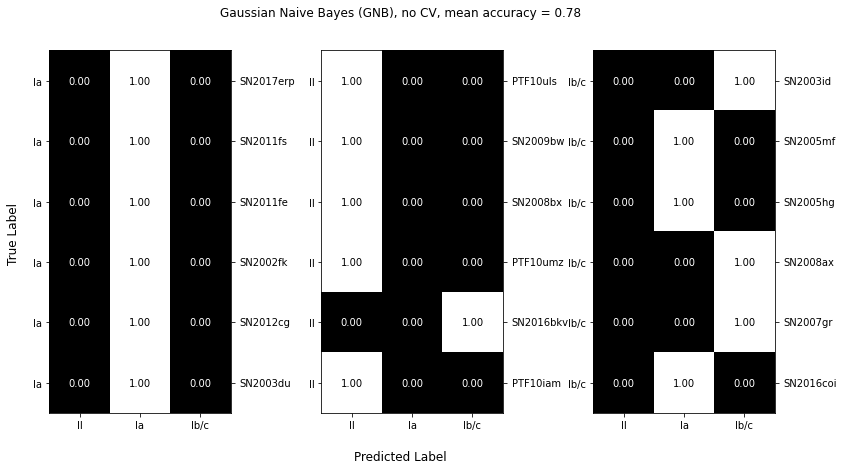

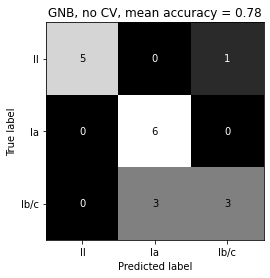

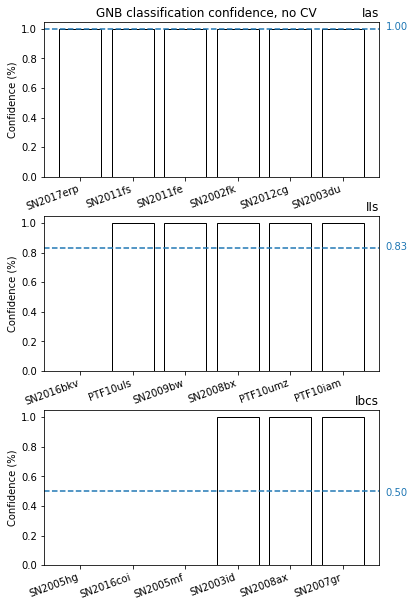

In [69]:
visualise_clf(gnb1_clf, CV=False)

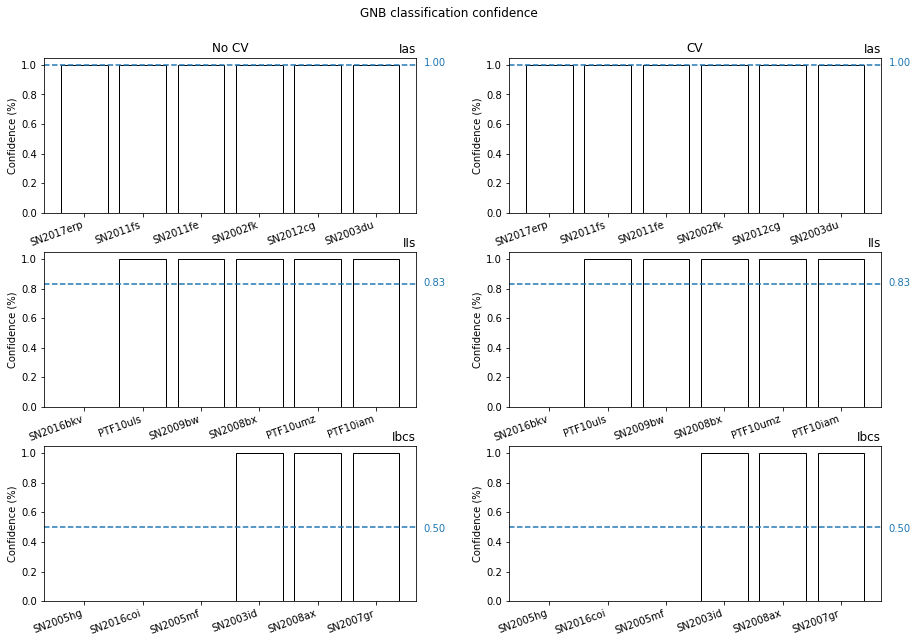

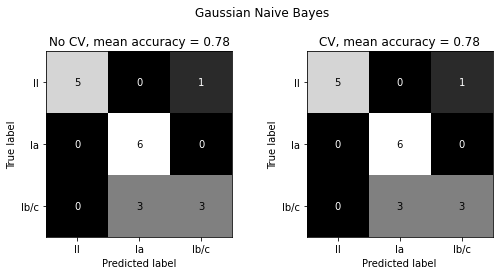

In [70]:
compare_cv(gnb_clf,gnb1_clf)

## Linear Discriminant Analysis (LDA)

LDA works by finding the components of the parameter space that best describes the variance of the data. In this case, since the LCs are interpolated to a grid of 200 points, they can be considered a 200 dimensional vector. LDA will act to find the components of this 200 dimensional space that describes the difference between the different SN type (ie what features of the LC are the most distinguishable between the three types).

Since this algorithm performed the best in both accuracy and confidence (which is explored in the next notebook), my understanding is that the light curves alone are sufficient enough to distinguish between the different classes. However, since the data were manually picked, this may introduce bias. For example, in reality, some Ias do not have a bump, so if a Ia without was detected and went for classification using this algorithm, it would very likely be classed as a type Ib/c, since the bump seems to be the main feature differntiating these classes. Therefore, if more light curve features are considered, such as rise times, gradients etc., these may act to further distinguish between classes.

### Links:
- LDA [user guide](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)
- LDA [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)


In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [72]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

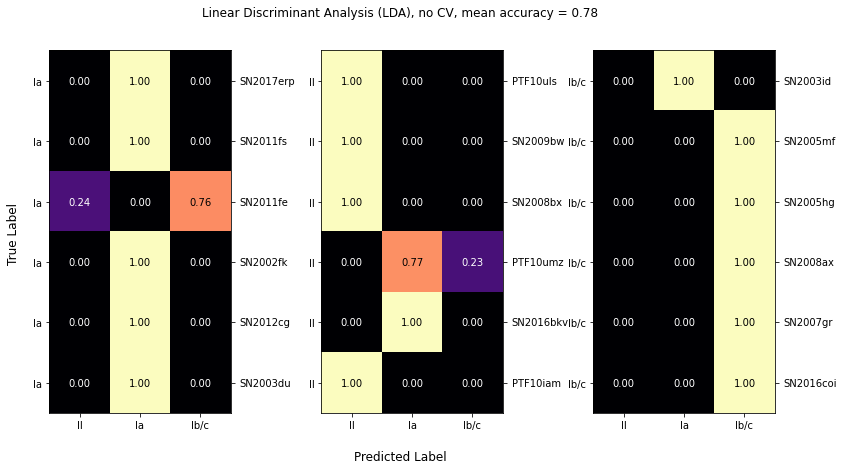

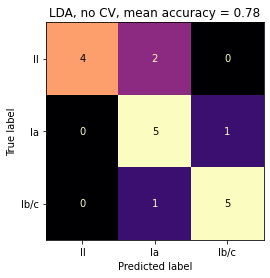

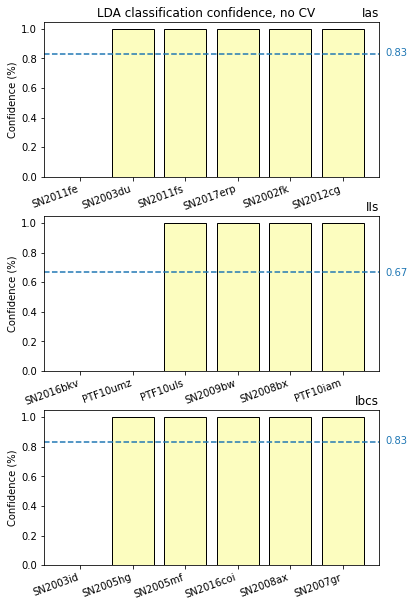

In [73]:
visualise_clf(lda_clf, CV=False)

In [74]:
param_grid_lda = [
  {'solver': ['svd','lsqr','eigen'],
   'shrinkage':['auto',0.05,0.1,0.15,1]
  }
]
optimal_params_lda = GridSearchCV(
        LinearDiscriminantAnalysis(), 
        param_grid_lda,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )

t0=time.time()
optimal_params_lda.fit(X_train, y_train)
print('\n Finished in %.2f seconds.' % float(time.time()-t0))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .........................shrinkage=auto, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=auto, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=auto, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=auto, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=auto, solver=svd; total time=   0.0s
[CV] END ........................shrinkage=auto, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=auto, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=auto, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=auto, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=auto, solver=lsqr; total time=   0.0s
[CV] END .......................shrinkage=auto, solver=eigen; total time=   0.0s
[CV] END .......................shrinkage=auto, 

In [75]:
lda1_clf = optimal_params_lda.best_estimator_
lda1_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

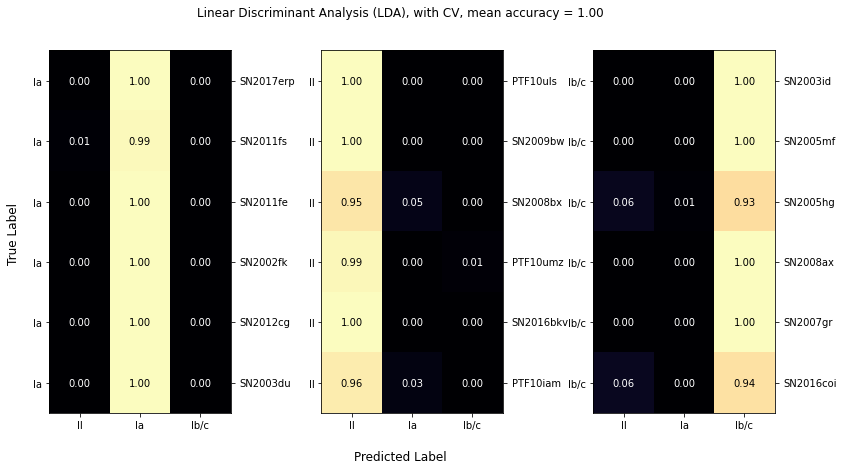

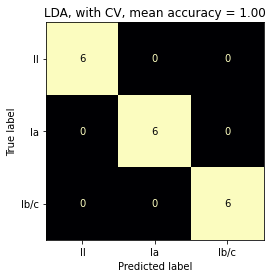

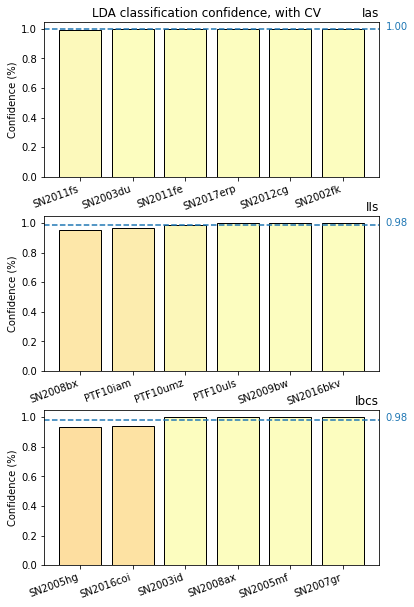

In [76]:
visualise_clf(lda1_clf, CV=True)

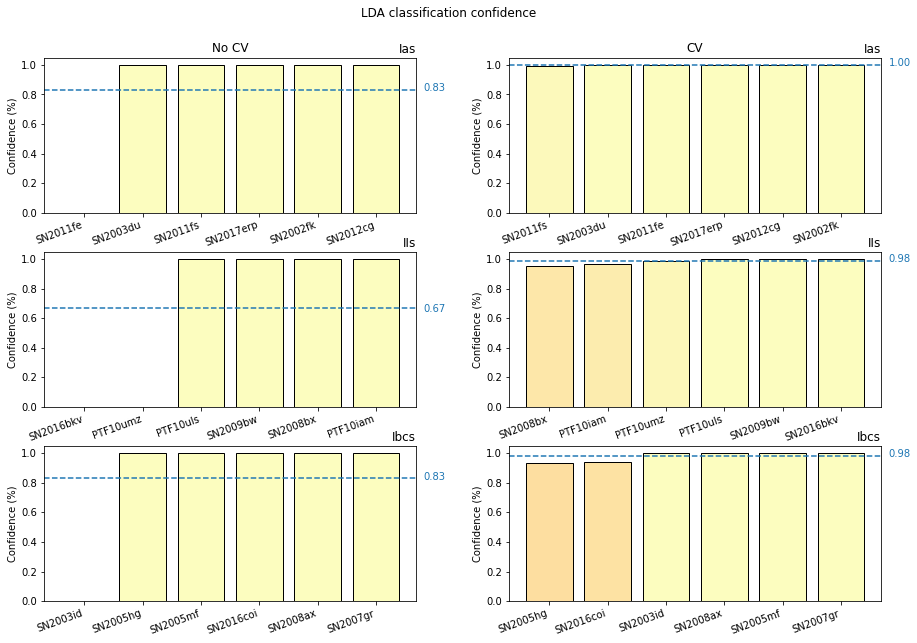

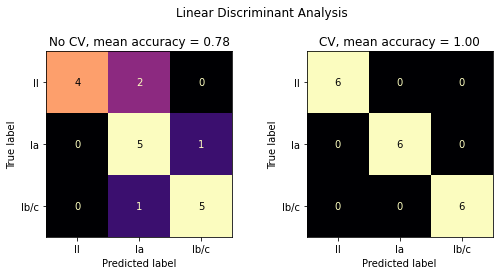

In [77]:
compare_cv(lda_clf,lda1_clf)